# Introduction to Using Azure OpenAI Service with Python

Welcome to this tutorial on using the Azure OpenAI service with Python. In this notebook, we will walk you through the steps to set up and use the Azure OpenAI service to interact with a Large Language Model (LLM). We will cover key Python concepts and provide explanations at each step.

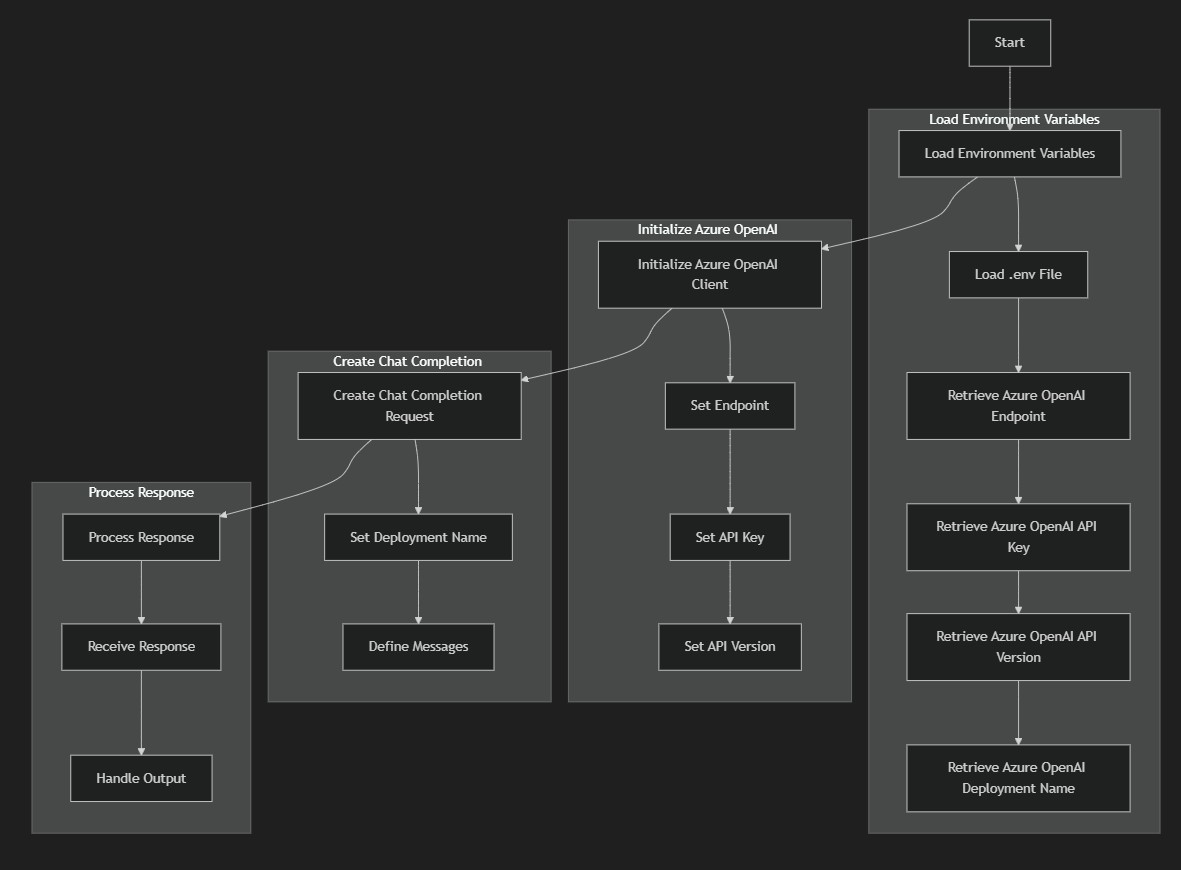

## Prerequisites

Before we begin, make sure you have the following:
- An Azure account with access to the Azure OpenAI service.
- Python installed on your machine.
- The `dotenv` and `openai` Python packages installed. You can install them using the following command:
```python
!pip install -r requirements.txt

# Sentiment Analysis in Python - Proof of Concept (POC)

The inspiratiion and credit for this POC goes to Rob Mulla: 
https://www.youtube.com/watch?v=QpzMWQvxXWk&t=492s


## Introduction - Busines Use Case & Requirements

Below is the list of the original and starting point for this POC

* For positive reviews (ratings 4 or 5), determine the top specific topics that reflect product aspects that customers appreciate, using clear language (e.g., 'pleasant scent' or 'durable packaging'). These topics should reveal aspects of the brand or product that are motivating buyers to leave positive reviews.

* For negative reviews (ratings 1, 2, or 3), identify the top specific topics that capture common customer complaints or issues, using precise wording (e.g., 'tablets do not fully dissolve' or 'pump mechanism fails'). These topics should reveal aspects of the brand or product that are motivating buyers to leave negative reviews.

* Present these topics as short phrases that make each sentiment's focus clear

* For each specific positive and negative topics identified, graph the trend of mentions over time for these topics.

* Provide a trend summary for each topic. Are mentions of this topic increasing, decreasing, or remaining steady? Have there been any spikes or dips in mentions of this product over time?


## Part 1 - Analyzing the data using Exploratory Data Analysi (EDA) Methodology

### Introduction

Objective is to upload the data, and become familiar with the content, to create a baseline that will help us to validate the POC when using LLM to analyze this same sample data.

By the end of this first section, we will be able to analyze the data and gain a similar evaluation assessment result over the sample data provided:

| Input | Negative | Neutral | Positive | Compound |
|----------|----------|----------|----------| ----------|
| "This computer is a good deal." | 0 | 0.58 | 0.42 | 0.44|
| "This computer is a very good deal" | 0 | 0.61 | 0.39 | 0.49 |
| "This computer is a very good deal!!" | 0 | 0.57 | 0.43 | 0.58 |
| "This computer is a very good deal!! :-)" | 0 | 0.44 | 0.56 | 0.74 |
| "This computer is a VERY good deal!! :-)" | 0 | 0.393 | 0.61 | 0.82 |


### Step 1 - Read the CSV data using Pandas and Natural Language Tool Kit (NLTK) Basics

### Step 1: Importing Required Libraries

First, we need to imort the necessary libraries. We will use the `dotenv` library to load environment variables from a `.env` file located in this project, and the `openai` python library to interact with the Azure OpenAI service.

In [1]:
# Import System Libraries to read .env file with login credentials to AI Resource
import os

# Import Required Libraries EDA Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px
import nbformat

# Import Required Libraries for Data Preprocessing of Sentiment Analysis
import openai
import nltk
nltk.download('all') # Download all the required NLTK data files instead of downloading one by one

from nltk.tokenize import word_tokenize
from nltk.corpus import conll2000
from nltk.chunk import conlltags2tree, tree2conlltags
from nltk.chunk import ne_chunk
from nltk import pos_tag
from nltk.sentiment import SentimentIntensityAnalyzer

# Nice Complements for Jupyter Notebook, these libraries will help to display the progress bar and the output in a more readable format
from tqdm.notebook import tqdm
from pprint import pprint

# Import the TextBlob library for working with textual data
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import PIL.Image


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\diegomartos\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\diegomartos\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\diegomartos\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     C:\Users\diegomartos\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\diegomartos\

### Step 2: Loading Environment Variables

We will load the Azure AIML Resource environment variables from a `.env` file. This file should contain the necessary credentials and endpoints for the Azure OpenAI Service.

In [2]:
# Retrieve the environment variables
aoai_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
aoai_api_key = os.getenv("AZURE_OPENAI_API_KEY")
aoai_deployment_name = os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME")
aoai_api_version = "2024-10-01-preview"

# Print the endpoint to verify it's loaded correctly
print(f"Azure OpenAI API Version: {aoai_api_version}")

Azure OpenAI API Version: 2024-10-01-preview


### Step 3: Initializing the Azure OpenAI Client

Next, we will initialize the Azure OpenAI client using the endpoint and API Key Retrived from the environment variables.

In [3]:
# Initialize the Azure OpenAI client
client = openai.AzureOpenAI(
    azure_endpoint=aoai_endpoint,
    api_key=aoai_api_key,
    api_version=aoai_api_version
)

### Step 4: Immporting the data

Now we will be importing data from the following source: https://amazon-reviews-2023.github.io/

This is about Amazon Product Purchase 5-Star Rating Review

In [4]:
subfolder_name: str = "source_data/"
file_name: str = "All_Beauty.jsonl"
df = pd.read_json(subfolder_name + file_name, lines=True)

In [5]:
df.head(100)

rating                                      title  \
0        5  Such a lovely scent but not overpowering.   
1        4     Works great but smells a little weird.   
2        5                                       Yes!   
3        1                          Synthetic feeling   
4        5                                         A+   
..     ...                                        ...   
95       5                                    Gentle!   
96       5                               Moisturizing   
97       4                         Leaves Teeth Clean   
98       3                   Doesn't Irritate My Skin   
99       4                               Easy to Use!   

                                                 text images        asin  \
0   This spray is really nice. It smells really go...     []  B00YQ6X8EO   
1   This product does what I need it to do, I just...     []  B081TJ8YS3   
2                           Smells good, feels great!     []  B07PNNCSP9   
3                                      Felt synthetic     []  B09JS339BZ   
4                                             Love it     []  B08BZ63GMJ   
..                                                ...    ...         ...   
95  This goat milk cleanser is very gentle. I have...     []  B07NPWK167   
96  'Tis the season for dry hands! I go through a ...     []  B07J2QZBTP   
97  I've used sonic toothbrushes before. I like th...     []  B07N45YN6C   
98  I am in my early 50's and have been a regular ...     []  B077YR3333   
99  My husband started a business recently and was...     []  B07FZ5HZLM   

   parent_asin                       user_id               timestamp  \
0   B00YQ6X8EO  AGKHLEW2SOWHNMFQIJGBECAF7INQ 2020-05-05 14:08:48.923   
1   B081TJ8YS3  AGKHLEW2SOWHNMFQIJGBECAF7INQ 2020-05-04 18:10:55.070   
2   B097R46CSY  AE74DYR3QUGVPZJ3P7RFWBGIX7XQ 2020-05-16 21:41:06.052   
3   B09JS339BZ  AFQLNQNQYFWQZPJQZS6V3NZU4QBQ 2022-01-28 18:13:50.220   
4   B08BZ63GMJ  AFQLNQNQYFWQZPJQZS6V3NZU4QBQ 2020-12-30 10:02:43.534   
..         ...                           ...                     ...   
95  B07NPWK167  AHV6QCNBJNSGLATP56JAWJ3C4G2A 2020-01-13 15:08:09.878   
96  B07J2QZBTP  AHV6QCNBJNSGLATP56JAWJ3C4G2A 2019-12-22 14:19:15.925   
97  B07N45YN6C  AHV6QCNBJNSGLATP56JAWJ3C4G2A 2019-07-08 01:44:25.320   
98  B077YR3333  AHV6QCNBJNSGLATP56JAWJ3C4G2A 2019-02-19 15:04:57.518   
99  B07FZ5HZLM  AHV6QCNBJNSGLATP56JAWJ3C4G2A 2019-01-21 17:46:13.968   

    helpful_vote  verified_purchase  
0              0               True  
1              1               True  
2              2               True  
3              0               True  
4              0               True  
..           ...                ...  
95             0              False  
96             0              False  
97             0              False  
98             0              False  
99             0              False  

[100 rows x 10 columns]

In [6]:
# Inserts a new column on most left side of the dataframe called Index to keep track of the original index
df_mod = df

df_mod['myID'] = range(1, len(df) + 1)
# Set 'myID' as the index
df_mod.set_index('myID', inplace=True)

# Display the DataFrame
df_mod.head()

rating                                      title  \
myID                                                      
1          5  Such a lovely scent but not overpowering.   
2          4     Works great but smells a little weird.   
3          5                                       Yes!   
4          1                          Synthetic feeling   
5          5                                         A+   

                                                   text images        asin  \
myID                                                                         
1     This spray is really nice. It smells really go...     []  B00YQ6X8EO   
2     This product does what I need it to do, I just...     []  B081TJ8YS3   
3                             Smells good, feels great!     []  B07PNNCSP9   
4                                        Felt synthetic     []  B09JS339BZ   
5                                               Love it     []  B08BZ63GMJ   

     parent_asin                       user_id               timestamp  \
myID                                                                     
1     B00YQ6X8EO  AGKHLEW2SOWHNMFQIJGBECAF7INQ 2020-05-05 14:08:48.923   
2     B081TJ8YS3  AGKHLEW2SOWHNMFQIJGBECAF7INQ 2020-05-04 18:10:55.070   
3     B097R46CSY  AE74DYR3QUGVPZJ3P7RFWBGIX7XQ 2020-05-16 21:41:06.052   
4     B09JS339BZ  AFQLNQNQYFWQZPJQZS6V3NZU4QBQ 2022-01-28 18:13:50.220   
5     B08BZ63GMJ  AFQLNQNQYFWQZPJQZS6V3NZU4QBQ 2020-12-30 10:02:43.534   

      helpful_vote  verified_purchase  
myID                                   
1                0               True  
2                1               True  
3                2               True  
4                0               True  
5                0               True

### Step 5: Preliminary Exploratory data Insights

Now let's gather get some high level insights by exploring the data based on the sample above

In [7]:
# uses pandas to count the number of records in the dataset
df_total_rows = len(df_mod)
# Uses pandas to count how many unique asin products found in the dataset
df_unique_asin_count = df_mod['asin'].nunique() 
print(f"In this dataset, there is a total of {df_total_rows} reviews, with a count of {df_unique_asin_count} unique  ASIN as count of unique products with review.")

In this dataset, there is a total of 701528 reviews, with a count of 115709 unique  ASIN as count of unique products with review.


In [8]:
# creates a list of the count of total reviews for each asin product id, \
# and displays in descending order
df_asin_review_count = df_mod['asin'].value_counts()
df_asin_review_count

B007IAE5WY    1962
B00EEN2HCS    1750
B07C533XCW    1513
B00R1TAN7I    1372
B08L5KN7X4    1343
              ... 
B06XHKHRF3       1
B07JHF2H3W       1
B07YXY78NT       1
B07DGL45JF       1
B01N3R1HDV       1
Name: asin, Length: 115709, dtype: int64

In [ ]:
# Provides insights of the time period of the reviews
df_mod['reviewTime'] = pd.to_datetime(df_mod['timestamp'])
df_mod['reviewYear'] = df_mod['reviewTime'].dt.year
df_mod['reviewMonth'] = df_mod['reviewTime'].dt.month

# Uses pandas to count the number of reviews per year and display the ratings per year \
# as a pivot table
pivot_table = df_mod.pivot_table(index='reviewYear', 
                                 columns='rating', 
                                 values='asin', 
                                 aggfunc='count')
pivot_table

rating            1       2        3        4        5
reviewYear                                            
2000            NaN     NaN      NaN      NaN      1.0
2001            NaN     1.0      NaN      2.0      9.0
2002            1.0     NaN      3.0      5.0     15.0
2003            1.0     3.0      4.0     16.0     32.0
2004           10.0    13.0     10.0     32.0     69.0
2005           25.0    18.0     27.0     77.0    120.0
2006           43.0    26.0     52.0    108.0    190.0
2007           69.0    85.0     98.0    311.0    599.0
2008           95.0    73.0    112.0    302.0    687.0
2009          100.0    91.0     86.0    247.0    683.0
2010          154.0    99.0    125.0    274.0    934.0
2011          247.0   123.0    179.0    303.0   1025.0
2012          316.0   162.0    231.0    445.0   1649.0
2013          688.0   431.0    708.0   1219.0   4902.0
2014         1427.0   882.0   1336.0   2254.0  10380.0
2015         3246.0  2050.0   2933.0   5180.0  22830.0
2016         6300.0  3588.0   5371.0   8973.0  38515.0
2017         8374.0  4244.0   5829.0   8754.0  40834.0
2018        10259.0  4578.0   5993.0   8388.0  43489.0
2019        13689.0  5453.0   6883.0  10178.0  62917.0
2020        18908.0  7507.0   9828.0  13178.0  77332.0
2021        23836.0  8649.0  10238.0  11803.0  70371.0
2022        11827.0  4063.0   5123.0   5906.0  34662.0
2023         2465.0   895.0   1138.0   1426.0   8481.0

In [10]:
# Adds a new column to the pivot_table with the total number of reviews per year
pivot_table['Total Reviews'] = pivot_table.sum(axis=1)
pivot_table

rating            1       2        3        4        5  Total Reviews
reviewYear                                                           
2000            NaN     NaN      NaN      NaN      1.0            1.0
2001            NaN     1.0      NaN      2.0      9.0           12.0
2002            1.0     NaN      3.0      5.0     15.0           24.0
2003            1.0     3.0      4.0     16.0     32.0           56.0
2004           10.0    13.0     10.0     32.0     69.0          134.0
2005           25.0    18.0     27.0     77.0    120.0          267.0
2006           43.0    26.0     52.0    108.0    190.0          419.0
2007           69.0    85.0     98.0    311.0    599.0         1162.0
2008           95.0    73.0    112.0    302.0    687.0         1269.0
2009          100.0    91.0     86.0    247.0    683.0         1207.0
2010          154.0    99.0    125.0    274.0    934.0         1586.0
2011          247.0   123.0    179.0    303.0   1025.0         1877.0
2012          316.0   162.0    231.0    445.0   1649.0         2803.0
2013          688.0   431.0    708.0   1219.0   4902.0         7948.0
2014         1427.0   882.0   1336.0   2254.0  10380.0        16279.0
2015         3246.0  2050.0   2933.0   5180.0  22830.0        36239.0
2016         6300.0  3588.0   5371.0   8973.0  38515.0        62747.0
2017         8374.0  4244.0   5829.0   8754.0  40834.0        68035.0
2018        10259.0  4578.0   5993.0   8388.0  43489.0        72707.0
2019        13689.0  5453.0   6883.0  10178.0  62917.0        99120.0
2020        18908.0  7507.0   9828.0  13178.0  77332.0       126753.0
2021        23836.0  8649.0  10238.0  11803.0  70371.0       124897.0
2022        11827.0  4063.0   5123.0   5906.0  34662.0        61581.0
2023         2465.0   895.0   1138.0   1426.0   8481.0        14405.0

<Axes: title={'center': 'Total Reviews per Year'}, xlabel='Year', ylabel='Total Reviews'>

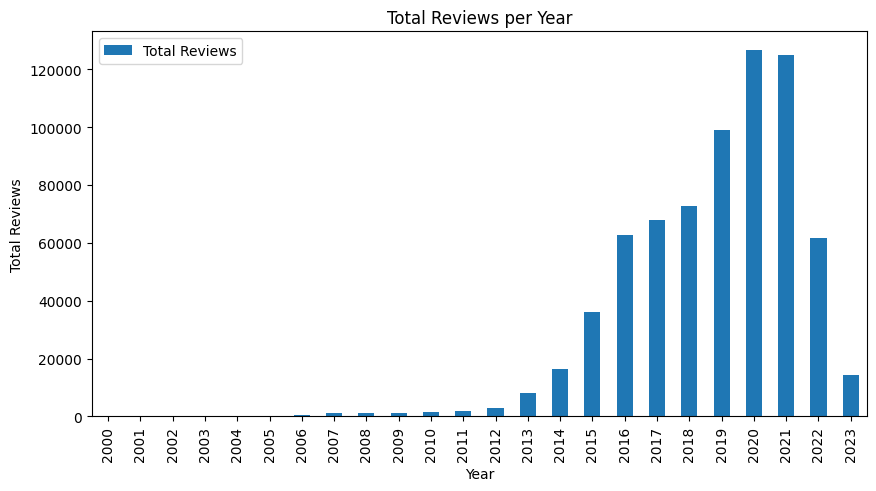

In [11]:
# Now let's create a bar chart plot using the ratings as x-axis and the total reviews as y-axis per year
pivot_table.plot(kind='bar', 
                 y='Total Reviews', 
                 title='Total Reviews per Year', 
                 ylabel='Total Reviews', 
                 xlabel='Year', 
                 figsize=(10, 5))


### Part 5: Exploring the Customer Reviews

So now, as the next step, let's explore the non-traditional unstructure data, and gain some preliminary insights to see what take to assess the words most observed for the products in the review.
This will help us to get some feeling of user responses that lead to their ratings and will help us to gain some more insights over the data we are working with.

1. Importance of Data Science in Amazon Reviews:

* Understanding Customer Sentiment: Analyzing reviews helps uncover customer preferences and pain points.
* Exploratory Data Analysis (EDA): Identifies patterns and trends within reviews for valuable insights.
* Word Cloud: Visual tool to highlight frequently occurring words and themes in reviews.

2. Philosophical Evaluation of Data Transformation:

* From Data to Knowledge: Converting raw data into actionable information and knowledge.
* Value of Customer Reviews: Both positive and negative reviews provide insights and influence future buyers.
* Respecting Customer Effort: Acknowledging the time and effort customers invest in writing reviews.
* Driving Innovation: Using feedback to improve products and better serve the market.




In [104]:
# Part of Speech Tagging, this will remove fillings, pronouns, and other words that do not add value to the sentiment analysis
stopwords = STOPWORDS
# Adds additional words to the stopwords list
stopwords = stopwords.add("br")

# Joins all strings from the review column in the 'Review' column of the data frame into a single string
text = " ".join(review for review in df_mod['text'])

# Creates a word cloud object with the text data, using the microsoft logo as a mask
wc_mask = np.array(PIL.Image.open("msft.jpg"))
colormap = ImageColorGenerator(wc_mask)

# creates the variable called 'wc' that will store the word cloud object
wc = WordCloud(stopwords=stopwords, 
               mask=wc_mask,
               background_color="white", 
               contour_color='steelblue',
               contour_width=3,
               colormap="Dark2",
               max_font_size=150, 
               random_state=42).generate(text)


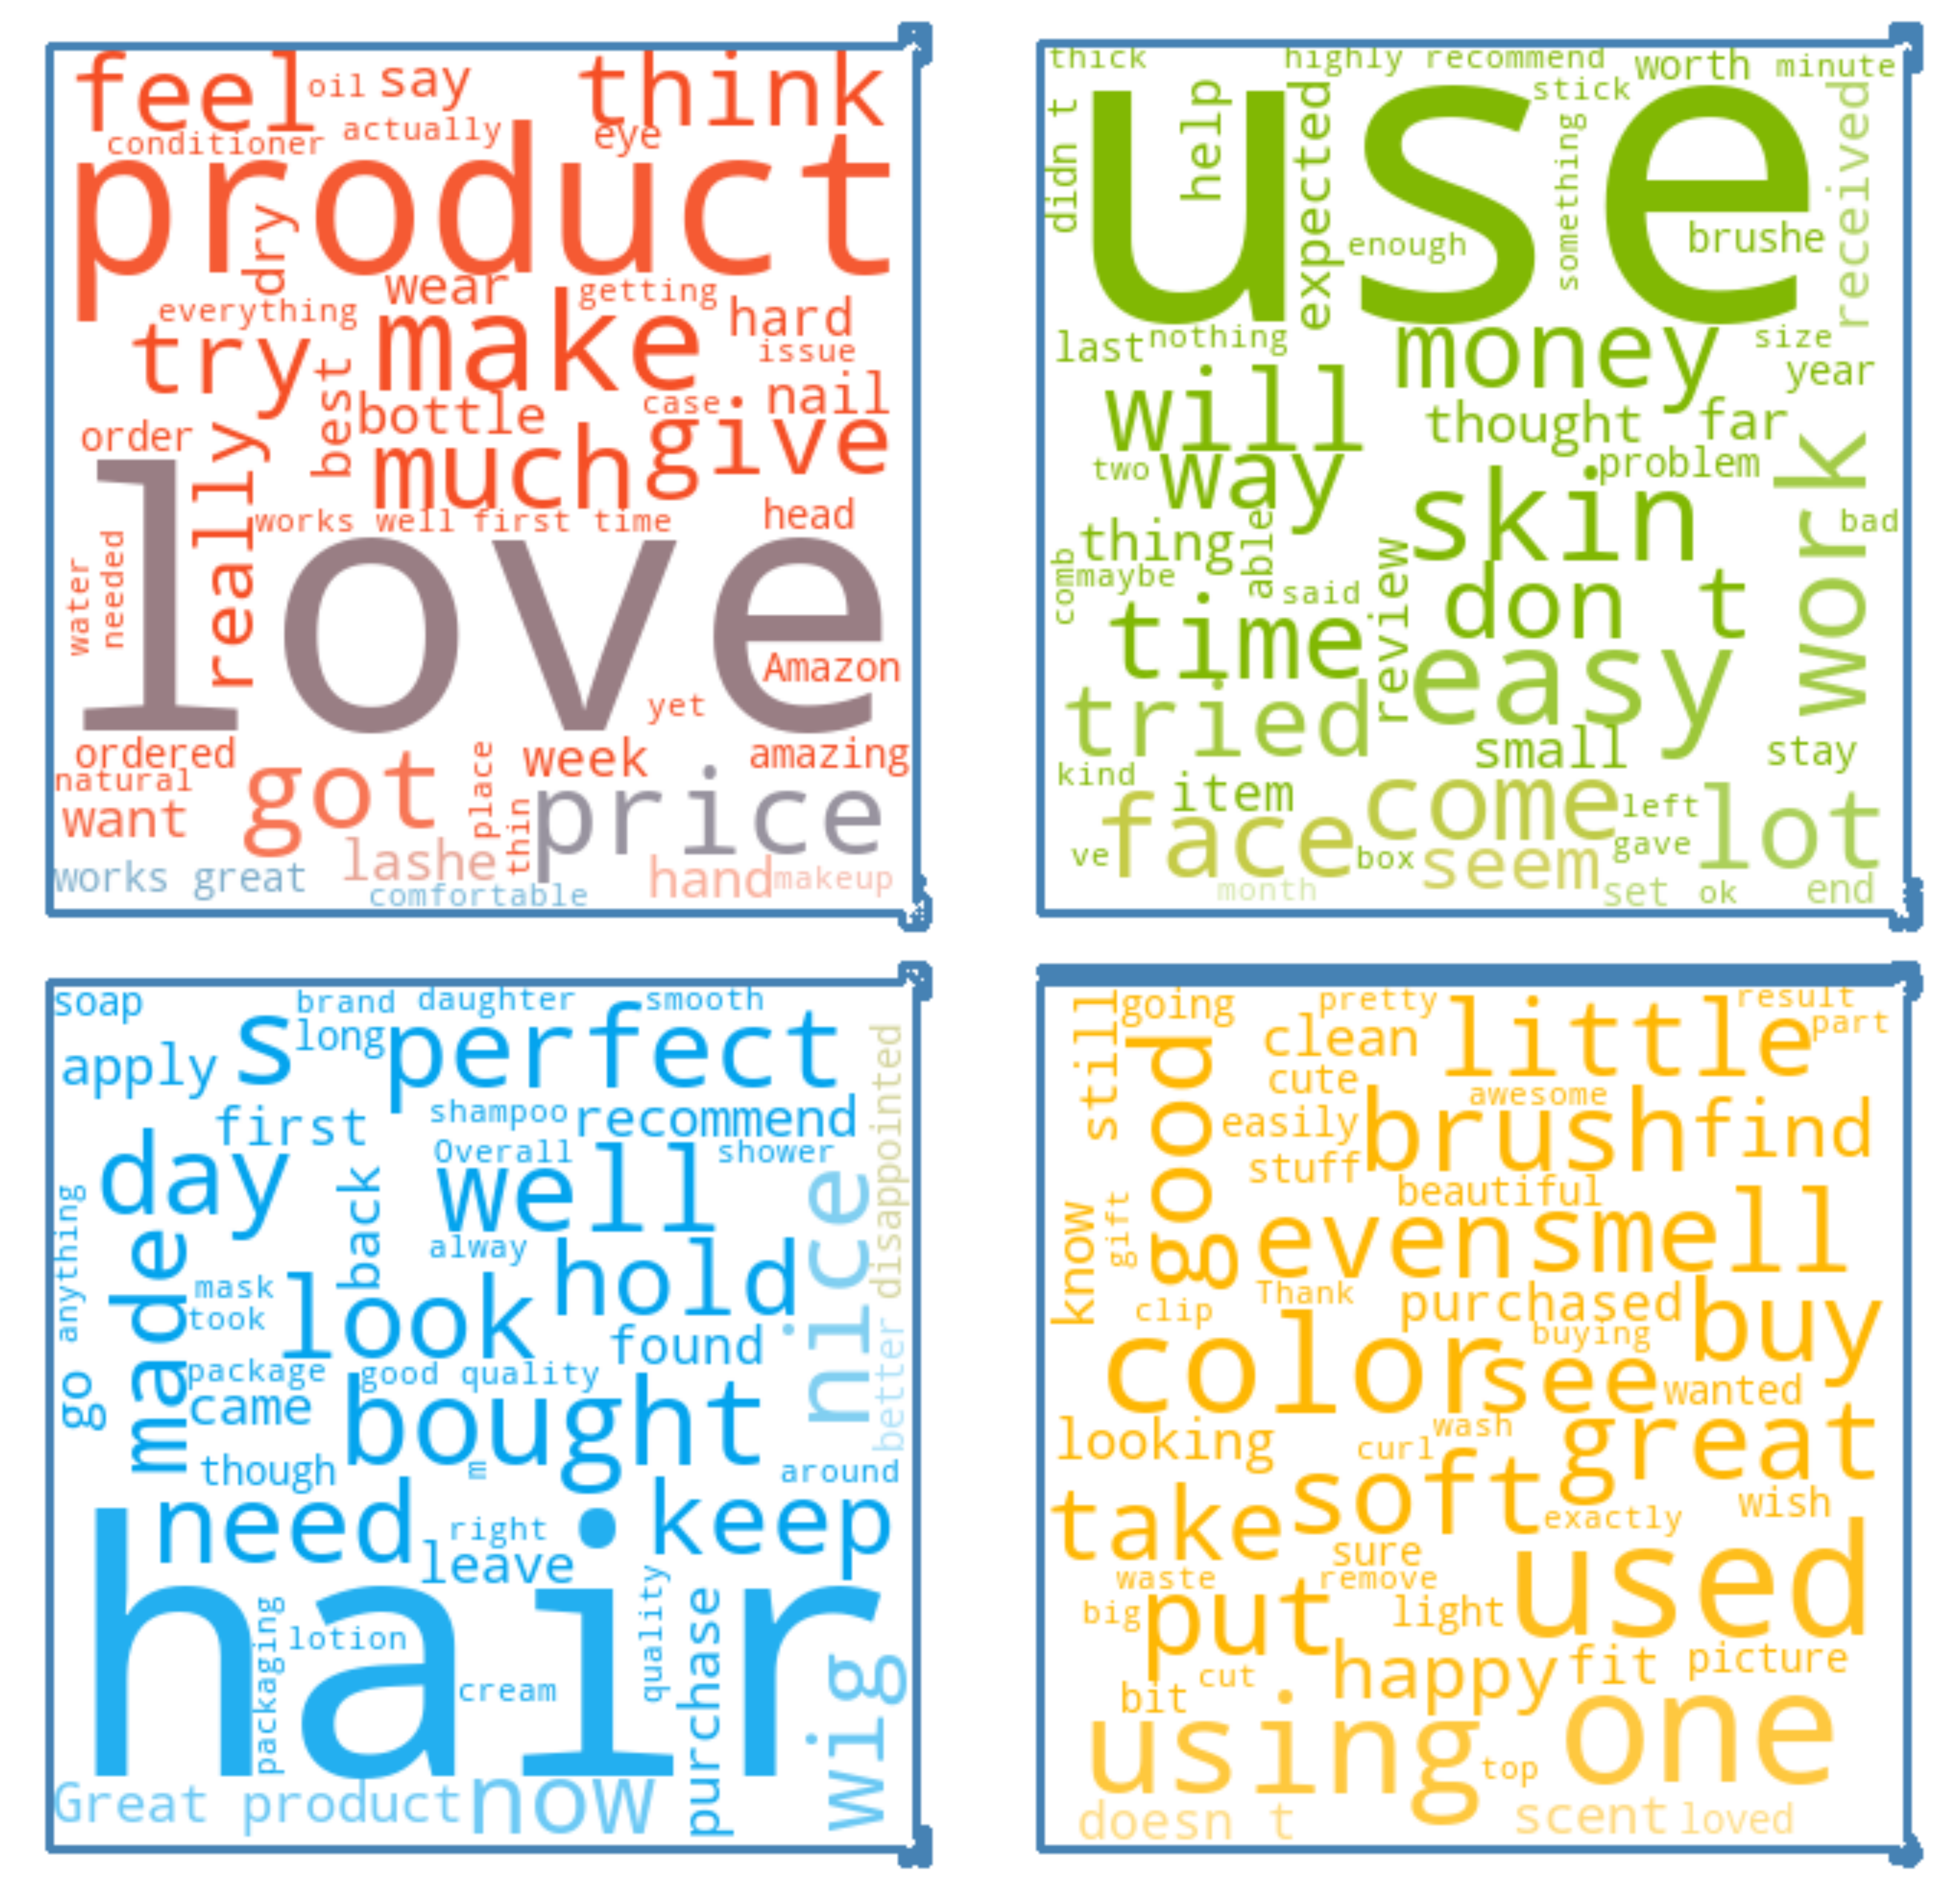

In [105]:
# displays the word cloud object
wc.recolor(color_func=colormap)

# Display the word cloud image using plt.imshow
plt.figure(figsize=(50, 50))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# Defines a variable to choose the number of top unique products to use as a subset of the original data frame
top_products_filter = 5 # Sets the number of top products to filter
bottom_products_filter = 5 # Sets the number of bottom products to filter

# Saves the ASIN of the top filtered products as a list for filtering the original data frame as a subset
top_products_list = df_mod['asin'].value_counts().head(top_products_filter).index.tolist()

# Saves the ASIN of the bottom filtered products as a list for filtering the original data frame as a subset
bottom_products_list = df_mod['asin'].value_counts().tail(bottom_products_filter).index.tolist()


# Displays the top products as a list
print("The top five products with total reviews are", top_products_list)
print("The bottom five products with total reviews are", bottom_products_list)

The top five products with total reviews are ['B007IAE5WY', 'B00EEN2HCS', 'B07C533XCW', 'B00R1TAN7I', 'B08L5KN7X4']
The bottom five products with total reviews are ['B06XHKHRF3', 'B07JHF2H3W', 'B07YXY78NT', 'B07DGL45JF', 'B01N3R1HDV']


In [21]:
# Creates a word cloud object with the text data, using the microsoft logo as a mask
wc_mask_top = np.array(PIL.Image.open("python_logo.png"))
colormap_top = ImageColorGenerator(wc_mask_top)

# Creates a word cloud object with the top products as a subset of the original data frame
top_products_text = " ".join(review for review in df_mod
                             [df_mod['asin'].isin(top_products_list)]['text']
                             )

wc_top_products = WordCloud(stopwords=stopwords, 
                            mask=wc_mask_top,
                            background_color="white", 
                            contour_color='steelblue',
                            contour_width=3,
                            colormap="Dark2",
                            max_font_size=150, 
                            random_state=42).generate(top_products_text)


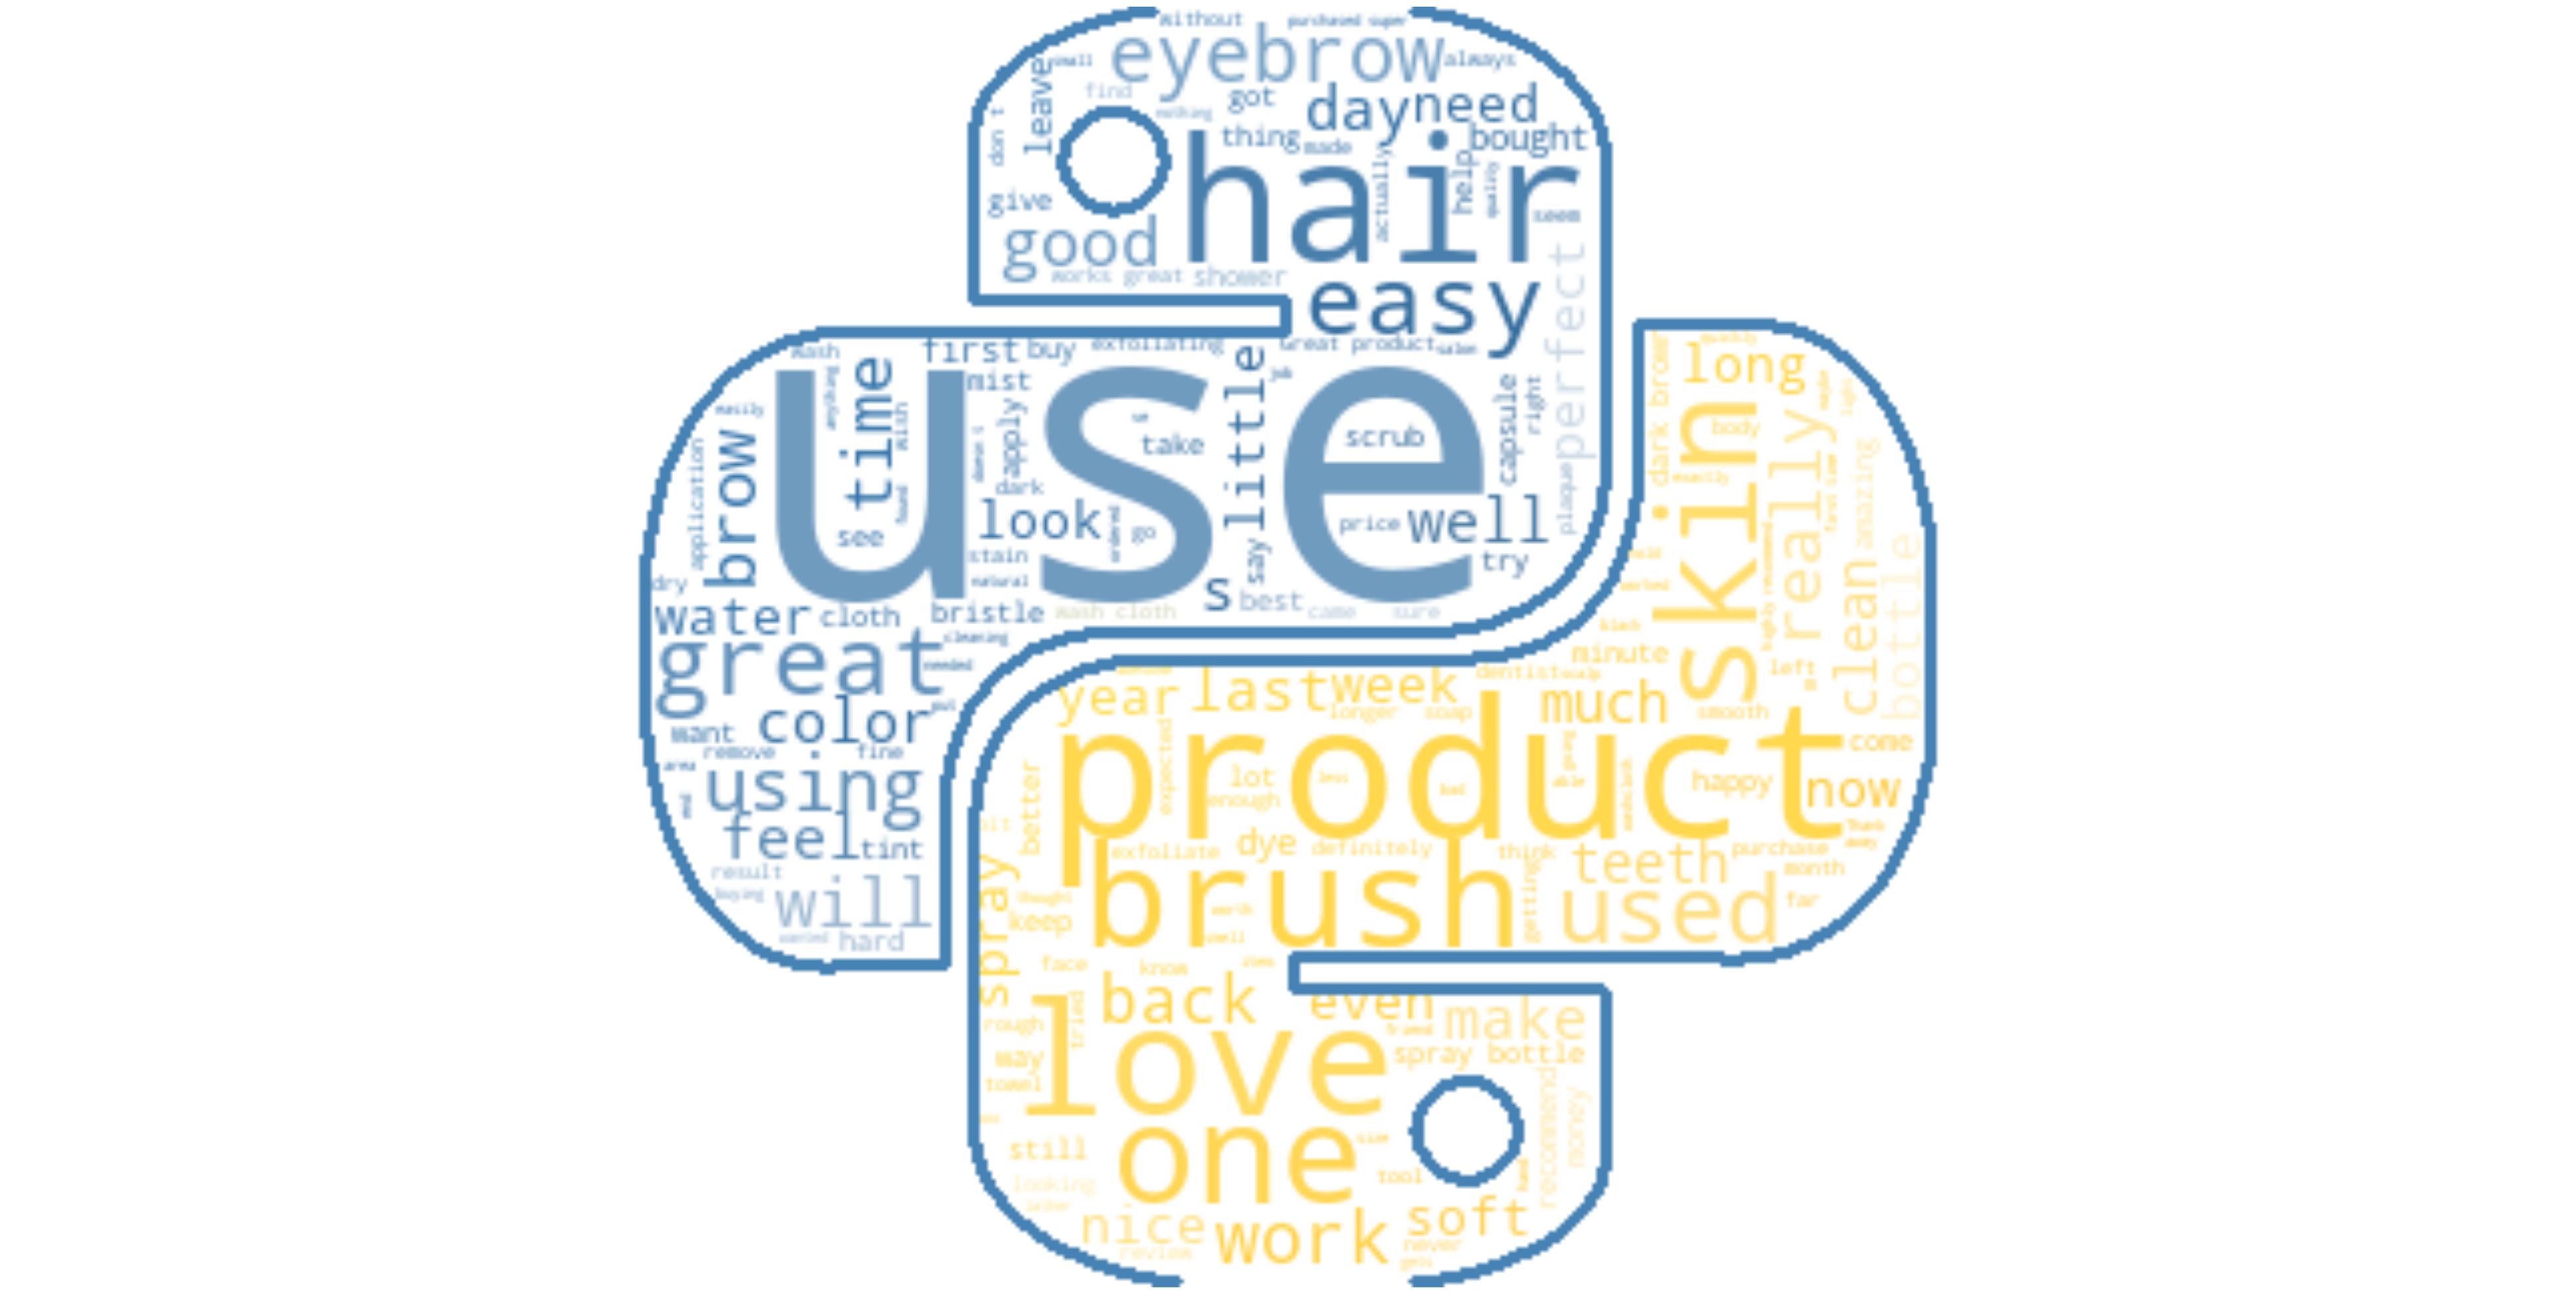

In [22]:
# displays the word cloud object
wc_top_products.recolor(color_func=colormap_top)

# Display the word cloud image using plt.imshow
plt.figure(figsize=(50, 50))
plt.imshow(wc_top_products, interpolation='bilinear')
plt.axis('off')
plt.show()

In [23]:

# Uses the 'isin' list method to filter the original data frame with the top products list
top_products_ratings_df = df_mod[
    df_mod['asin'].isin(top_products_list)
    ]

# Displays the first 5 rows of the top products ratings data frame
top_products_ratings_df.head()


rating                            title  \
myID                                            
187        3                Typical exfolient   
483        4                Salux Wathclothes   
563        5                       Five Stars   
1032       5                       Five Stars   
1033       5  easy to use and very affordable   

                                                   text images        asin  \
myID                                                                         
187   Whats all the hype about? Its no different tha...     []  B007IAE5WY   
483   Love these! The bumps on my legs finally gone!...     []  B007IAE5WY   
563   This product is great. It is easy to use and l...     []  B00EEN2HCS   
1032  My Husband Loves it... firm bristles soothes h...     []  B00R1TAN7I   
1033  I like this because it is small compact and ea...     []  B08L5KN7X4   

     parent_asin                       user_id               timestamp  \
myID                                                                     
187   B085BB7B1M  AF4NIQPIZQ3S3G6KEVQW33DNHZSQ 2015-07-07 17:26:54.000   
483   B085BB7B1M  AEXTSZOMHUDQZ46764RKBNZ2WANA 2017-05-23 13:44:15.000   
563   B0BM4GX6TT  AFOMMZPFMNVCAC6VYYGQPJSRZFTQ 2018-07-29 17:41:32.264   
1032  B00R1TAN7I  AEB5LQL4K2OFE2LT5H5BDPQLNZTQ 2015-07-17 11:40:55.000   
1033  B08L5KN7X4  AEAHMJFRN3ZP4ZCVO5PVLDHWXUWQ 2021-07-27 00:11:24.613   

      helpful_vote  verified_purchase              reviewTime  reviewYear  \
myID                                                                        
187              1               True 2015-07-07 17:26:54.000        2015   
483              0               True 2017-05-23 13:44:15.000        2017   
563              0               True 2018-07-29 17:41:32.264        2018   
1032             0               True 2015-07-17 11:40:55.000        2015   
1033             0               True 2021-07-27 00:11:24.613        2021   

      reviewMonth  
myID               
187             7  
483             5  
563             7  
1032            7  
1033            7

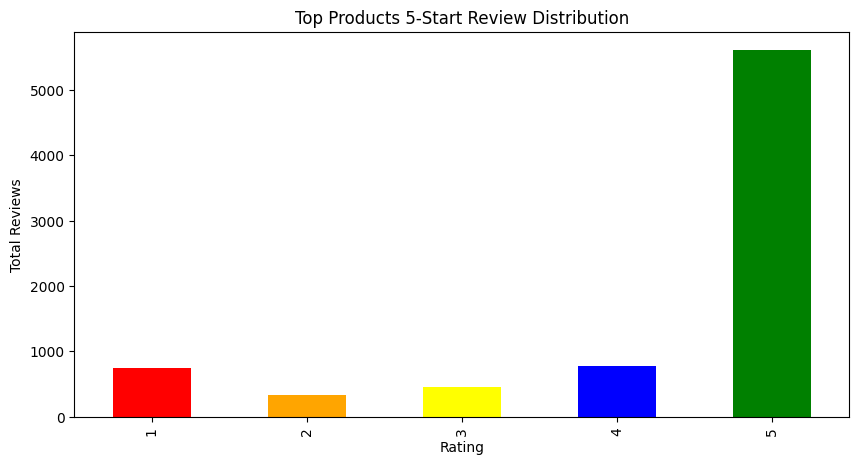

In [24]:

# Displays the ratings distribution of the top products as a bar chart

# Sets a list of colors to use in the bar chart for 5-star ratings distribution
colors = ['red', 'orange', 'yellow', 'blue', 'green']

# Uses the 'value_counts' method to count the number of ratings for the top products
ax = top_products_ratings_df['rating'].value_counts().sort_index().plot(kind='bar', 
                                                   title='Top Products 5-Start Review Distribution', 
                                                   color=colors,
                                                   ylabel='Total Reviews', 
                                                   xlabel='Rating', 
                                                   figsize=(10, 5))

ax.set_ylabel('Total Reviews')
plt.show()


In [25]:
# Displays the count of 1-5 start ratings for each of the top reviewed products in a pivot table format
pivot_table_top_products = top_products_ratings_df.pivot_table(index='asin', 
                                                               columns='rating', 
                                                               values='text', 
                                                               aggfunc='count')
pivot_table_top_products

rating        1    2    3    4     5
asin                                
B007IAE5WY   85   38   71  149  1619
B00EEN2HCS  180   88  147  235  1100
B00R1TAN7I  137  103  126  217   789
B07C533XCW  119   33   63  103  1195
B08L5KN7X4  225   77   55   81   905

In [26]:
# Adds a new column to the pivot_table with the total number of reviews per product
pivot_table_top_products['Total Reviews'] = pivot_table_top_products.sum(axis=1)
pivot_table_top_products

rating        1    2    3    4     5  Total Reviews
asin                                               
B007IAE5WY   85   38   71  149  1619           1962
B00EEN2HCS  180   88  147  235  1100           1750
B00R1TAN7I  137  103  126  217   789           1372
B07C533XCW  119   33   63  103  1195           1513
B08L5KN7X4  225   77   55   81   905           1343

In [27]:
# Creates a style sheet that will be used for all the plots
plt.style.use('ggplot')

# Displays the top_products_ratings as a treemap plot with 1-5 start ratings distribution by product
px.treemap(top_products_ratings_df,
           path=['asin', 'rating'],
           title='Top Products 1-5 Start Review Distribution',
           color='rating', 
           color_continuous_scale='RdBu', 
           width=800, 
           height=800)

## Part 2: Sentiment Analysis using offline AIML Python Libraries (NLTK Package)

### Basic NLTK Analysis 

Now that we see that ratings are trending to good reviews, at least for the top products with the total count of review records, let's perform some basic natural language review of the comments for the ratings and see if that aligns with the number of starts ranked by each customer review.

Let's first apply the NLTK to generate a sentiment score based on part of speech by breaking down one of the reviews left in the comments based on "bag of words" as a weighted score for a compound score.

NTLK will generate a ranking of each sentence based on driver words found in the sentence. For this, the computer will use a dictionary and break down the words in a sentence into tokens, and evaluate according with the disctonary below.



Here is the alphabetical list of part-of-speech (POS) tags used in the Penn Treebank Project:
| Number | Tag | Description |
|----------|----------|----------|
| 1. | CC | Coordinating conjunction |
| 2. |	CD | Cardinal number |
| 3. |	DT | Determiner |
| 4. |	EX | Existential there |
| 5. |	FW | Foreign word |
| 6. |	IN | Preposition or subordinating conjunction |
| 7. |	JJ | Adjective |
| 8. |	JJR | Adjective, comparative |
| 9. |	JJS | Adjective, superlative |
| 10. |	LS | List item marker |
| 11. |	MD | Modal |
| 12. |	NN | Noun, singular or mass |
| 13. |	NNS | Noun, plural |
| 14. |	NNP | Proper noun, singular |
| 15. |	NNPS | Proper noun, plural |
| 16. |	PDT | Predeterminer |
| 17. |	POS | Possessive ending |
| 18. |	PRP | Personal pronoun |
| 19. |	PRP$ | Possessive pronoun |
| 20. |	RB | Adverb |
| 21. |	RBR | Adverb, comparative |
| 22. |	RBS | Adverb, superlative |
| 23. |	RP | Particle |
| 24. |	SYM | Symbol |
| 25. |	TO | to |
| 26. |	UH | Interjection |
| 27. |	VB | Verb, base form |
| 28. |	VBD | Verb, past tense |
| 29. |	VBG | Verb, gerund or present participle |
| 30. |	VBN | Verb, past participle |
| 31. |	VBP | Verb, non-3rd person singular present |
| 32. |	VBZ	| Verb, 3rd person singular present |
| 33. |	WDT | Wh-determiner |
| 34. |	WP | Wh-pronoun |
| 35. |	WP$ | Possessive wh-pronoun |
| 36. |	WRB | Wh-adverb |

In [28]:
# Display the column names of top_products_ratings data frame
top_products_ratings_df.columns

Index(['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase', 'reviewTime',
       'reviewYear', 'reviewMonth'],
      dtype='object')

In [29]:
# saves the 7th comment in the 'text' column of the top_products_ratings data frame as a variable called '7th_comment' and displays for user
seventh_comment = top_products_ratings_df['text'].iloc[7]
seventh_comment

'Just sad that I did not know of this product much earlier. Much better than a wash rag, or wash towel, much more durable, and because of its texture it does help to get rid of dead skin, that appears are always present, in less or greater quantities. Dries fairly soon, and because of its tiny pores and antibacterial capabilities, it barely hold on to odors as long as it is properly washed and rinsed before hanging. Nice invention, pretty darn smart, if you ask me. Long enough for a person to do their own back, and works like one with liquid soap creating plenty of clean foam. 4 Stars for this japanese product.'

In [30]:
# Uses NLTK to tokenize the 7th comment above   
tokens = nltk.word_tokenize(seventh_comment)
print("Tokens:", tokens)

Tokens: ['Just', 'sad', 'that', 'I', 'did', 'not', 'know', 'of', 'this', 'product', 'much', 'earlier', '.', 'Much', 'better', 'than', 'a', 'wash', 'rag', ',', 'or', 'wash', 'towel', ',', 'much', 'more', 'durable', ',', 'and', 'because', 'of', 'its', 'texture', 'it', 'does', 'help', 'to', 'get', 'rid', 'of', 'dead', 'skin', ',', 'that', 'appears', 'are', 'always', 'present', ',', 'in', 'less', 'or', 'greater', 'quantities', '.', 'Dries', 'fairly', 'soon', ',', 'and', 'because', 'of', 'its', 'tiny', 'pores', 'and', 'antibacterial', 'capabilities', ',', 'it', 'barely', 'hold', 'on', 'to', 'odors', 'as', 'long', 'as', 'it', 'is', 'properly', 'washed', 'and', 'rinsed', 'before', 'hanging', '.', 'Nice', 'invention', ',', 'pretty', 'darn', 'smart', ',', 'if', 'you', 'ask', 'me', '.', 'Long', 'enough', 'for', 'a', 'person', 'to', 'do', 'their', 'own', 'back', ',', 'and', 'works', 'like', 'one', 'with', 'liquid', 'soap', 'creating', 'plenty', 'of', 'clean', 'foam', '.', '4', 'Stars', 'for', 'th

In [31]:
# Uses NLTK to tag the tokens in the 7th comment above
tagged = nltk.pos_tag(tokens)
# Displays the tagged tokens
tagged[:20]

[('Just', 'RB'),
 ('sad', 'JJ'),
 ('that', 'IN'),
 ('I', 'PRP'),
 ('did', 'VBD'),
 ('not', 'RB'),
 ('know', 'VB'),
 ('of', 'IN'),
 ('this', 'DT'),
 ('product', 'NN'),
 ('much', 'RB'),
 ('earlier', 'RBR'),
 ('.', '.'),
 ('Much', 'RB'),
 ('better', 'JJR'),
 ('than', 'IN'),
 ('a', 'DT'),
 ('wash', 'JJ'),
 ('rag', 'NN'),
 (',', ',')]

### Step 1: Perform VADER Sentiment Scorking using NLTK offline Python Library

We will use NLTK's SentimentINtensityAnalyzer to get the negative/neutral/positive scores of the text

* This uses a "bag of words" approach
 1. Stop words are removed (And, the, etc...)
 2. each word is scored and combined to a total sentence score

In [32]:
# Creates an object called 'sentiment' that will store the SentimentIntensityAnalyzer object
sia = SentimentIntensityAnalyzer()

In [33]:
# Example of using the sia polarity_scores method to analyze the sentiment of the 7th sentence in the 'text' column of the top_products_ratings data frame
print("Recap of sample example review:", seventh_comment)
sia.polarity_scores(seventh_comment)

Recap of sample example review: Just sad that I did not know of this product much earlier. Much better than a wash rag, or wash towel, much more durable, and because of its texture it does help to get rid of dead skin, that appears are always present, in less or greater quantities. Dries fairly soon, and because of its tiny pores and antibacterial capabilities, it barely hold on to odors as long as it is properly washed and rinsed before hanging. Nice invention, pretty darn smart, if you ask me. Long enough for a person to do their own back, and works like one with liquid soap creating plenty of clean foam. 4 Stars for this japanese product.


{'neg': 0.057, 'neu': 0.76, 'pos': 0.184, 'compound': 0.9263}

As we have enabled successfully a function able to detect the sentiment from customer feedback review, let's run this polarity score on all reviews for the top products with highest number of reviews

In [34]:
# Run the polarity score on the entire dataset
res = {} # Create an empty dictionary to store the results
# Iterate over each row in the data frame
for index, row in tqdm(top_products_ratings_df.iterrows(), total=len(top_products_ratings_df)): 
    res[index] = sia.polarity_scores(row['text']) # Store the results in the dictionary

  0%|          | 0/7940 [00:00<?, ?it/s]

In [46]:
res

{187: {'neg': 0.129, 'neu': 0.733, 'pos': 0.138, 'compound': 0.0772},
 483: {'neg': 0.0, 'neu': 0.598, 'pos': 0.402, 'compound': 0.9198},
 563: {'neg': 0.0, 'neu': 0.57, 'pos': 0.43, 'compound': 0.8687},
 1032: {'neg': 0.0, 'neu': 0.684, 'pos': 0.316, 'compound': 0.5719},
 1033: {'neg': 0.0, 'neu': 0.625, 'pos': 0.375, 'compound': 0.6597},
 1038: {'neg': 0.386, 'neu': 0.614, 'pos': 0.0, 'compound': -0.7425},
 1364: {'neg': 0.073, 'neu': 0.815, 'pos': 0.111, 'compound': 0.34},
 1948: {'neg': 0.057, 'neu': 0.76, 'pos': 0.184, 'compound': 0.9263},
 2187: {'neg': 0.101, 'neu': 0.6, 'pos': 0.299, 'compound': 0.7405},
 2245: {'neg': 0.0, 'neu': 0.82, 'pos': 0.18, 'compound': 0.296},
 2283: {'neg': 0.028, 'neu': 0.885, 'pos': 0.087, 'compound': 0.9403},
 2435: {'neg': 0.008, 'neu': 0.824, 'pos': 0.168, 'compound': 0.9689},
 2938: {'neg': 0.059, 'neu': 0.863, 'pos': 0.078, 'compound': 0.1935},
 3373: {'neg': 0.0, 'neu': 0.548, 'pos': 0.452, 'compound': 0.8718},
 3384: {'neg': 0.0, 'neu': 1.0, 

Now that we have a way to aggreage the sentiment of a sentence, keep the range for the 4 weights according to it's range:
| Polarity | Starting Range | Ending Range |
| ----- | ----- | ----- |
| Negative ('neg')  | 0 (Low likelely hood) | 1 (High Likely hood)  |
| Neutral ('neu') | 0 (Low likelely hood) | 1 (High Likely hood)  |
| Positive ('pos') | 0 (Low likelely hood) | 1 (High Likely hood)  |
| Compound ('comp') | -1 (Negative likelely hood) | +1 (Positive Likely hood)  |

### Step 2: Applying Exploratory Data Analysi based on NLTK Sentiment Analysis

In [36]:
# Convert the dictionary to a data frame and Transposes the result
vaders_df = pd.DataFrame(res).T
vaders_df.head()

neg    neu    pos  compound
187   0.129  0.733  0.138    0.0772
483   0.000  0.598  0.402    0.9198
563   0.000  0.570  0.430    0.8687
1032  0.000  0.684  0.316    0.5719
1033  0.000  0.625  0.375    0.6597

In [37]:
# Merges the vaders data frame with the top_products_ratings data frame as \
# a new data frame called 'top_products_ratings_vaders'
top_products_ratings_vaders = pd.concat([top_products_ratings_df, vaders_df], axis=1)
# Displays the first 5 rows of the new top_products_ratings_vaders data frame
top_products_ratings_vaders.head()

rating                            title  \
187        3                Typical exfolient   
483        4                Salux Wathclothes   
563        5                       Five Stars   
1032       5                       Five Stars   
1033       5  easy to use and very affordable   

                                                   text images        asin  \
187   Whats all the hype about? Its no different tha...     []  B007IAE5WY   
483   Love these! The bumps on my legs finally gone!...     []  B007IAE5WY   
563   This product is great. It is easy to use and l...     []  B00EEN2HCS   
1032  My Husband Loves it... firm bristles soothes h...     []  B00R1TAN7I   
1033  I like this because it is small compact and ea...     []  B08L5KN7X4   

     parent_asin                       user_id               timestamp  \
187   B085BB7B1M  AF4NIQPIZQ3S3G6KEVQW33DNHZSQ 2015-07-07 17:26:54.000   
483   B085BB7B1M  AEXTSZOMHUDQZ46764RKBNZ2WANA 2017-05-23 13:44:15.000   
563   B0BM4GX6TT  AFOMMZPFMNVCAC6VYYGQPJSRZFTQ 2018-07-29 17:41:32.264   
1032  B00R1TAN7I  AEB5LQL4K2OFE2LT5H5BDPQLNZTQ 2015-07-17 11:40:55.000   
1033  B08L5KN7X4  AEAHMJFRN3ZP4ZCVO5PVLDHWXUWQ 2021-07-27 00:11:24.613   

      helpful_vote  verified_purchase              reviewTime  reviewYear  \
187              1               True 2015-07-07 17:26:54.000        2015   
483              0               True 2017-05-23 13:44:15.000        2017   
563              0               True 2018-07-29 17:41:32.264        2018   
1032             0               True 2015-07-17 11:40:55.000        2015   
1033             0               True 2021-07-27 00:11:24.613        2021   

      reviewMonth    neg    neu    pos  compound  
187             7  0.129  0.733  0.138    0.0772  
483             5  0.000  0.598  0.402    0.9198  
563             7  0.000  0.570  0.430    0.8687  
1032            7  0.000  0.684  0.316    0.5719  
1033            7  0.000  0.625  0.375    0.6597

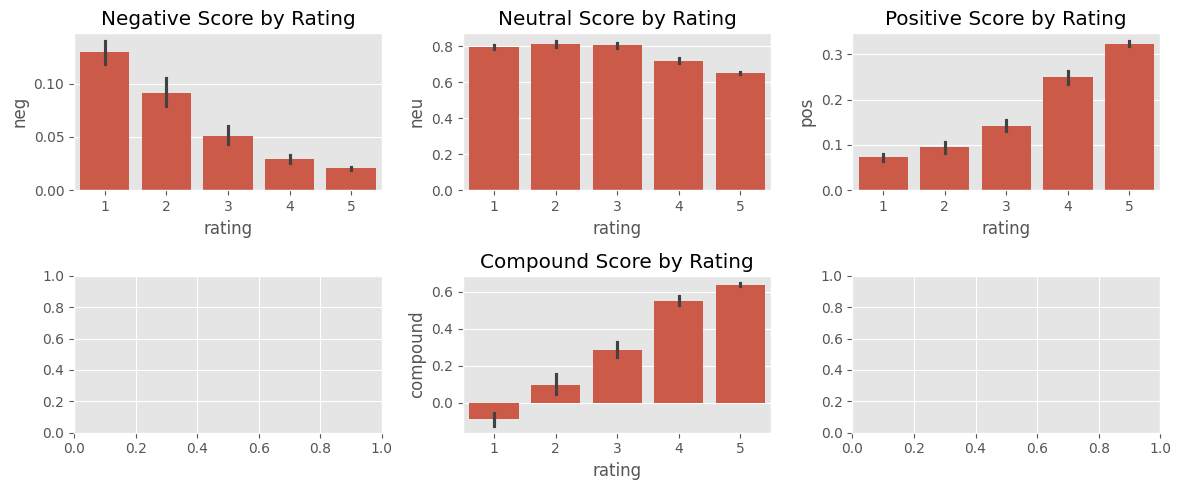

In [38]:
fig, axs = plt.subplots(2, 3, figsize=(12, 5))
sns.barplot(data=top_products_ratings_vaders, x='rating', y='neg', ax=axs[0, 0])
axs[0, 0].set_title('Negative Score by Rating')
sns.barplot(data=top_products_ratings_vaders, x='rating', y='neu', ax=axs[0, 1])
axs[0, 1].set_title('Neutral Score by Rating')
sns.barplot(data=top_products_ratings_vaders, x='rating', y='pos', ax=axs[0, 2])
axs[0, 2].set_title('Positive Score by Rating')
sns.barplot(data=top_products_ratings_vaders, x='rating', y='compound', ax=axs[1, 1])
axs[1, 1].set_title('Compound Score by Rating')
plt.tight_layout() # Adjust the layout to prevent overlapping
plt.show()

### Step 3: Summary Statistics and Aggregations

Summary of the Code:

* Displays summary statistics for numerical columns for top products.
* Displays the distribution of sentiments for top products.
* Groups by ASIN to see the average rating and most common sentiment for each top product.
* Groups by Date of Review to analyze trends over time for top products.
* Groups by Rating and Sentiment to identify any discrepancies for top products.

In [58]:
# Display summary statistics for numerical columns for top products
print(top_products_ratings_vaders.describe())

            rating  helpful_vote   reviewYear  reviewMonth          neg  \
count  7940.000000   7940.000000  7940.000000  7940.000000  7940.000000   
mean      4.280856      1.311461  2018.583627     6.278715     0.036550   
std       1.304680     15.975106     2.423004     3.338112     0.081226   
min       1.000000      0.000000  2012.000000     1.000000     0.000000   
25%       4.000000      0.000000  2016.000000     3.000000     0.000000   
50%       5.000000      0.000000  2019.000000     6.000000     0.000000   
75%       5.000000      0.000000  2021.000000     9.000000     0.045000   
max       5.000000    594.000000  2023.000000    12.000000     1.000000   

               neu          pos     compound  
count  7940.000000  7940.000000  7940.000000  
mean      0.689441     0.272620     0.517049  
std       0.213688     0.224475     0.432055  
min       0.000000     0.000000    -0.976000  
25%       0.585000     0.112000     0.338200  
50%       0.730000     0.225000     0.6486

### Partial Conclusion:
This NLTK offline model looks at each word in the sentence for each review and scored each word individually.
However, this method does not account for human language context, and on context. So if a sentence has a negative word but with a sarcastic speech tone, it would not pick up on relationship between words.

## Part 3 - Perform Sentiment Analysis using OpenAI LLM on top product with highest count of reviews 


### Step 1 Create an llm client to iterate with Azure Open AI service

We will first learn how to interact with Azure OpenAI via API Calls using an example, then we will iterate with the data subset to perform a negative, positive or neutral sentiment analysis of the customer review feeback in the comments of the product 5-star rating review.

In [39]:
# Generates a promt for the Azure OpenAI API to answer a question with a promt to train and educate the AI model on how to review the sentiment of a product
response = client.chat.completions.create(
    model = aoai_deployment_name,
    messages=[
        {"role": "system",
         "content": "You are an assistant that helps to assess product \
            review with a sentiment analysis. \
            your reponse should be always be a single lower case word included among the \
            following three options: positive, negative, neutral."},
         {"role": "user", 
          "content": "I never thought I would need this product so bad, \
            but this is the best product I have ever used!"}
         ]) 

In [40]:
# Print the final response content from the output message from the model
print('The sentiment analysis of the sample comment is: ', response.choices[0].message.content)

The sentiment analysis of the sample comment is:  positive


In [41]:
# Print the final response from the model with all attributes and values from the output message from the model
print(response)

ChatCompletion(id='chatcmpl-AcYahApiuGc9r8GkVbVionHnILUaY', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='positive', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None), content_filter_results={'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_code': {'filtered': False, 'detected': False}, 'protected_material_text': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}})], created=1733752795, model='gpt-4o-2024-08-06', object='chat.completion', service_tier=None, system_fingerprint='fp_04751d0b65', usage=CompletionUsage(completion_tokens=1, prompt_tokens=77, total_tokens=78, completion_tokens_details=None, prompt_tokens_details=None), prompt_filter_results=[{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': '

From the complete response from the model it is possible to extract not only sentiment but also the tokens, entities, and other attributes

In [42]:
# Print the tokens consumed by the prompt:
print('Tokens consumed to generate the request', response.usage.prompt_tokens) 
# Prints the tokens consumed by the completion response
print('Tokens consumed to generate the response', response.usage.completion_tokens) 
# Prints the total tokens consumed for this API Call:
print('Total Tokens per iteration',response.usage.total_tokens) 

Tokens consumed to generate the request 77
Tokens consumed to generate the response 1
Total Tokens per iteration 78


In [43]:
# We can use this to estimate the cost per API Call based on this sample:
# Example: The cost per token is $0.00000075
# The cost per API Call is $0.00000075 * response.usage.total_tokens

# Prints the total cost per API
print('Total estimated cost, in USD, per API Call: $', 0.00000075 * response.usage.total_tokens) 

Total estimated cost, in USD, per API Call: $ 5.85e-05


In [45]:
# Reminder of the columns in top_products_ratings_vaders data frame
top_products_ratings_vaders.head(2)

rating              title  \
187       3  Typical exfolient   
483       4  Salux Wathclothes   

                                                  text images        asin  \
187  Whats all the hype about? Its no different tha...     []  B007IAE5WY   
483  Love these! The bumps on my legs finally gone!...     []  B007IAE5WY   

    parent_asin                       user_id           timestamp  \
187  B085BB7B1M  AF4NIQPIZQ3S3G6KEVQW33DNHZSQ 2015-07-07 17:26:54   
483  B085BB7B1M  AEXTSZOMHUDQZ46764RKBNZ2WANA 2017-05-23 13:44:15   

     helpful_vote  verified_purchase          reviewTime  reviewYear  \
187             1               True 2015-07-07 17:26:54        2015   
483             0               True 2017-05-23 13:44:15        2017   

     reviewMonth    neg    neu    pos  compound  
187            7  0.129  0.733  0.138    0.0772  
483            5  0.000  0.598  0.402    0.9198

Now that we now how it works, how we can control and how much it would consume for the effort, let's run this against the data set and optain the sentiment analysis for the first 150 samples of the top reviews in the products with the highest count of total reviews

In [65]:
# Initialize an empty list to store sentiments and tokens
sentiments = []

# Initialize an empty list to store skipped reviews
skipped_reviews = []

# Defines a System Prompt to be used by the model:
system_prompt = "You are a marketing assistant that helps to assess product review with a sentiment analysis of the comment left in the text column in the dataset. \
    Your response should be always a single word, always in lower case and limited to ONLY ONE OF THE FOLLOWING three options: positive, negative, neutral."

# Limit the number of reviews to analyze
limit = 35

# Loop through each row in the data frame
for index, row in tqdm(top_products_ratings_vaders.iterrows(), total=limit): # Loop through each row in the data frame
    if len(sentiments) < limit: # Check if the limit has been reached
        try:
            response = client.chat.completions.create(
                model = aoai_deployment_name,
                messages=[
                    {"role": "system",
                     "content": system_prompt},
                    {"role": "user", 
                     "content": row['text']}]) # Use the text column in the data frame as the user input
            
            # Store the response attributes in variables
            llm_index_ref = index
            llm_sentiment = response.choices[0].message.content
            llm_prompt_tokens = response.usage.prompt_tokens
            llm_completion_tokens = response.usage.completion_tokens
            llm_total_tokens = response.usage.total_tokens
            # Append the sentiment to the list
            sentiments.append(
                {
                    # creates a unique index reference for the row
                    'llm_index_ref': llm_index_ref,
                    # llm sentiment is the sentiment returned by the model
                    'llm_sentiment': llm_sentiment,
                    # llm prompt tokens are the tokens consumed by the prompt
                    'PromptTokens': llm_prompt_tokens,
                    # llm completion tokens are the tokens consumed by the completion response
                    'CompletionTokens': llm_completion_tokens,
                    # llm total tokens are the total tokens consumed for this API Call
                    'TotalTokens': llm_total_tokens
                }
            )
        except Exception as e:
            # Print the error message as reviews do not meet the responsible AI model requirements and compliance.
            print(f"Error processing review: '{row['Review']}': {e}")
            # Append the review to the skipped reviews list
            skipped_reviews.append(row['text'])
    else:
        break

# Loop through each row in the data frame


  0%|          | 0/35 [00:00<?, ?it/s]

In [66]:
# Prints the sentiments list
print(sentiments)

[{'llm_index_ref': 187, 'llm_sentiment': 'negative', 'PromptTokens': 110, 'CompletionTokens': 1, 'TotalTokens': 111}, {'llm_index_ref': 483, 'llm_sentiment': 'positive', 'PromptTokens': 98, 'CompletionTokens': 1, 'TotalTokens': 99}, {'llm_index_ref': 563, 'llm_sentiment': 'positive', 'PromptTokens': 92, 'CompletionTokens': 1, 'TotalTokens': 93}, {'llm_index_ref': 1032, 'llm_sentiment': 'positive', 'PromptTokens': 82, 'CompletionTokens': 1, 'TotalTokens': 83}, {'llm_index_ref': 1033, 'llm_sentiment': 'positive', 'PromptTokens': 82, 'CompletionTokens': 1, 'TotalTokens': 83}, {'llm_index_ref': 1038, 'llm_sentiment': 'negative', 'PromptTokens': 87, 'CompletionTokens': 1, 'TotalTokens': 88}, {'llm_index_ref': 1364, 'llm_sentiment': 'positive', 'PromptTokens': 109, 'CompletionTokens': 1, 'TotalTokens': 110}, {'llm_index_ref': 1948, 'llm_sentiment': 'positive', 'PromptTokens': 203, 'CompletionTokens': 1, 'TotalTokens': 204}, {'llm_index_ref': 2187, 'llm_sentiment': 'positive', 'PromptTokens':

In [67]:
# Converts the  list of sentiments to a data frame in Pandas
sentiments_df = pd.DataFrame(sentiments)
# Shows the first 5 rows of the data frame 
sentiments_df

llm_index_ref llm_sentiment  PromptTokens  CompletionTokens  TotalTokens
0             187      negative           110                 1          111
1             483      positive            98                 1           99
2             563      positive            92                 1           93
3            1032      positive            82                 1           83
4            1033      positive            82                 1           83
5            1038      negative            87                 1           88
6            1364      positive           109                 1          110
7            1948      positive           203                 1          204
8            2187      positive            93                 1           94
9            2245       neutral            86                 1           87
10           2283      positive           333                 1          334
11           2435      positive           297                 1          298
12           2938      negative           180                 1          181
13           3373      positive            90                 1           91
14           3384      negative            81                 1           82
15           3399      positive            92                 1           93
16           3465      positive           134                 1          135
17           3486      positive           123                 1          124
18           3510      positive            72                 1           73
19           3517      positive           115                 1          116
20           3661      positive           107                 1          108
21           3934      positive           105                 1          106
22           3953      negative            99                 1          100
23           3967      positive           103                 1          104
24           4050      positive           164                 1          165
25           4053      positive           116                 1          117
26           4094      negative            73                 1           74
27           4108      positive           208                 1          209
28           4142       neutral            72                 1           73
29           4237      negative            99                 1          100
30           4239      positive           126                 1          127
31           4329      negative           112                 1          113
32           4400      positive           113                 1          114
33           4503      positive            96                 1           97
34           4561      positive            77                 1           78

In [68]:
# Display the distribution of Sentiment for top products
print(sentiments_df['llm_sentiment'].value_counts())

positive    25
negative     8
neutral      2
Name: llm_sentiment, dtype: int64


In [69]:
# Saves the successful results to a CSV file, using a naming convention with date and time to avoid overwriting previous results
sentiments_df.to_csv(f'sentiments_{pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")}.csv', index=False)

### Step 3: Estimates the cost of performing sentiment analysis on the evaluation data set

In [70]:
# Provides a count of total tokens consumed by the model among all records in the data frame
total_tokens = sentiments_df['TotalTokens'].sum()
# Estimated Cost per token as a variable in USD
cost_per_token = 0.00000075
# Calculates the total cost in USD
total_cost = cost_per_token * total_tokens
# Displays the total cost in USD
print(f'Total Tokens: {total_tokens}')
print(f'Estimated cost per token USD $: {cost_per_token}')
print(f'Total Tokens Consumed USD $: {total_cost}')

Total Tokens: 4264
Estimated cost per token USD $: 7.5e-07
Total Tokens Consumed USD $: 0.003198


Also, let's see how many records could not be processed with a sentiment analysis because of responsible AI compliance, if any:

* for more information, check the official documentation: `What is Responsible AI?: ` https://learn.microsoft.com/en-us/azure/machine-learning/concept-responsible-ai?view=azureml-api-2

In [71]:
# Convert the skipped reviews list to a DataFrame
skipped_reviews_df = pd.DataFrame(skipped_reviews)

# Creates a for loop to iterate over the skipped reviews list and display the first 5 rows \
# if errors are found in the reviews, else, prints that no errors were found
if len(skipped_reviews_df) > 0:
    print("The following reviews were skipped due to errors:")
    print(skipped_reviews_df.head())
else:
    print("No errors or non-compliants records were found in the reviews.")

No errors or non-compliants records were found in the reviews.


In [72]:
# Assuming vaders is your existing DataFrame

# Merge the sentiments_df with vaders DataFrame on the 'Id' column into a new DataFrame called nlp_combined_df
#nlp_combined_df = pd.merge(sentiments_df, top_products_ratings_vaders, left_on='llm_index_ref', right_index=True)

# Merge the sentiments_df on the right of vaders DataFrame on the 'Id' column into a new DataFrame called nlp_combined_df
nlp_combined_df = pd.merge(top_products_ratings_vaders, 
                           sentiments_df, 
                           left_index=True, 
                           right_on='llm_index_ref')

# Display the first 5 rows of the nlp_combined_df DataFrame
nlp_combined_df.head()


rating                            title  \
0       3                Typical exfolient   
1       4                Salux Wathclothes   
2       5                       Five Stars   
3       5                       Five Stars   
4       5  easy to use and very affordable   

                                                text images        asin  \
0  Whats all the hype about? Its no different tha...     []  B007IAE5WY   
1  Love these! The bumps on my legs finally gone!...     []  B007IAE5WY   
2  This product is great. It is easy to use and l...     []  B00EEN2HCS   
3  My Husband Loves it... firm bristles soothes h...     []  B00R1TAN7I   
4  I like this because it is small compact and ea...     []  B08L5KN7X4   

  parent_asin                       user_id               timestamp  \
0  B085BB7B1M  AF4NIQPIZQ3S3G6KEVQW33DNHZSQ 2015-07-07 17:26:54.000   
1  B085BB7B1M  AEXTSZOMHUDQZ46764RKBNZ2WANA 2017-05-23 13:44:15.000   
2  B0BM4GX6TT  AFOMMZPFMNVCAC6VYYGQPJSRZFTQ 2018-07-29 17:41:32.264   
3  B00R1TAN7I  AEB5LQL4K2OFE2LT5H5BDPQLNZTQ 2015-07-17 11:40:55.000   
4  B08L5KN7X4  AEAHMJFRN3ZP4ZCVO5PVLDHWXUWQ 2021-07-27 00:11:24.613   

   helpful_vote  verified_purchase  ... reviewMonth    neg    neu    pos  \
0             1               True  ...           7  0.129  0.733  0.138   
1             0               True  ...           5  0.000  0.598  0.402   
2             0               True  ...           7  0.000  0.570  0.430   
3             0               True  ...           7  0.000  0.684  0.316   
4             0               True  ...           7  0.000  0.625  0.375   

   compound  llm_index_ref  llm_sentiment  PromptTokens CompletionTokens  \
0    0.0772            187       negative           110                1   
1    0.9198            483       positive            98                1   
2    0.8687            563       positive            92                1   
3    0.5719           1032       positive            82                1   
4    0.6597           1033       positive            82                1   

   TotalTokens  
0          111  
1           99  
2           93  
3           83  
4           83  

[5 rows x 22 columns]

In [73]:
# drops the llm_index_ref column from the nlp_combined_df data frame and saves as a new dataframe called nlp_combined__final_df
nlp_combined_final_df = nlp_combined_df.drop(columns=['llm_index_ref'])

# Display the first 5 rows of the nlp_combined__final_df DataFrame
nlp_combined_final_df.head()

rating                            title  \
0       3                Typical exfolient   
1       4                Salux Wathclothes   
2       5                       Five Stars   
3       5                       Five Stars   
4       5  easy to use and very affordable   

                                                text images        asin  \
0  Whats all the hype about? Its no different tha...     []  B007IAE5WY   
1  Love these! The bumps on my legs finally gone!...     []  B007IAE5WY   
2  This product is great. It is easy to use and l...     []  B00EEN2HCS   
3  My Husband Loves it... firm bristles soothes h...     []  B00R1TAN7I   
4  I like this because it is small compact and ea...     []  B08L5KN7X4   

  parent_asin                       user_id               timestamp  \
0  B085BB7B1M  AF4NIQPIZQ3S3G6KEVQW33DNHZSQ 2015-07-07 17:26:54.000   
1  B085BB7B1M  AEXTSZOMHUDQZ46764RKBNZ2WANA 2017-05-23 13:44:15.000   
2  B0BM4GX6TT  AFOMMZPFMNVCAC6VYYGQPJSRZFTQ 2018-07-29 17:41:32.264   
3  B00R1TAN7I  AEB5LQL4K2OFE2LT5H5BDPQLNZTQ 2015-07-17 11:40:55.000   
4  B08L5KN7X4  AEAHMJFRN3ZP4ZCVO5PVLDHWXUWQ 2021-07-27 00:11:24.613   

   helpful_vote  verified_purchase  ... reviewYear  reviewMonth    neg    neu  \
0             1               True  ...       2015            7  0.129  0.733   
1             0               True  ...       2017            5  0.000  0.598   
2             0               True  ...       2018            7  0.000  0.570   
3             0               True  ...       2015            7  0.000  0.684   
4             0               True  ...       2021            7  0.000  0.625   

     pos  compound  llm_sentiment PromptTokens  CompletionTokens  TotalTokens  
0  0.138    0.0772       negative          110                 1          111  
1  0.402    0.9198       positive           98                 1           99  
2  0.430    0.8687       positive           92                 1           93  
3  0.316    0.5719       positive           82                 1           83  
4  0.375    0.6597       positive           82                 1           83  

[5 rows x 21 columns]

In [74]:
# Group by ASIN to see the average rating and sentiment distribution for each top product
top_asin_grouped = nlp_combined_final_df.groupby('asin').agg({
    'rating': 'mean',
    'neg': 'mean',	
    'neu': 'mean',
    'pos': 'mean',
    'compound': 'mean',
    'llm_sentiment': lambda x: x.value_counts().index[0]  # Most common sentiment
}).reset_index()
print(top_asin_grouped)

         asin    rating       neg       neu       pos  compound llm_sentiment
0  B007IAE5WY  4.600000  0.035333  0.676200  0.288467  0.695340      positive
1  B00EEN2HCS  3.500000  0.009833  0.817000  0.173167  0.439183      positive
2  B00R1TAN7I  3.666667  0.012000  0.678000  0.310000  0.483367      positive
3  B07C533XCW  3.500000  0.074875  0.809375  0.115625  0.219875      positive
4  B08L5KN7X4  3.666667  0.058667  0.692667  0.248667  0.458133      positive


### Step 4: Plot the Rating and compound columns over time for each product

To plot the top_asin_grouped DataFrame in a timeline at a daily level, showing both the Rating and compound columns over time for each of the top five products, you can follow these steps:

1. Ensure the Date of Review column is in datetime format.
2. Group the data by ASIN and Date of Review at a daily level.
3. Plot the Rating and compound columns over time for each product.

So first, let's ensure the Date of Review (timestamp) column is in datetime pandas format

In [ ]:
# Ensure 'Date of Review' is in datetime format
nlp_combined_final_df['timestamp'] = pd.to_datetime(nlp_combined_final_df['timestamp'], 
                                                    errors='coerce')

# Drop rows with NaT values in 'Date of Review' after conversion
nlp_combined_final_df = nlp_combined_final_df.dropna(subset=['timestamp'])

# If no records were dropped, print a message
if len(nlp_combined_final_df) == len(nlp_combined_final_df):
    print("No records were dropped.")
else:
    print(f"{len(nlp_combined_final_df)} records were dropped.")
    # Lists the asin products dropped
    print(nlp_combined_final_df['asin'].unique())

No records were dropped.


Then, let's proceed and group the data by ASIN and Date of Review at a daily level

In [79]:

# Identify the top 5 products with the highest number of reviews
top_products = nlp_combined_df['asin'].value_counts().head(5).index

# Filter the DataFrame to include only these top 5 products
top_products_df = nlp_combined_df[nlp_combined_final_df['asin'].isin(top_products)].copy()

# Group by 'ASIN' and 'Date of Review' at a daily level and calculate the mean of 'Rating' and 'compound'
top_asin_grouped = top_products_df.groupby(['asin', 
                                            'timestamp']).agg({'rating': 'mean',
                                                               'compound': 'mean'}).reset_index()

In [80]:
top_asin_grouped.describe()

rating   compound
count  35.000000  35.000000
mean    4.000000   0.504249
std     1.514634   0.473424
min     1.000000  -0.742500
25%     3.500000   0.135350
50%     5.000000   0.659700
75%     5.000000   0.897900
max     5.000000   0.969800

In [81]:
# Group by Date of Review to analyze trends over time for top products
top_date_grouped = top_products_df.groupby('timestamp').agg({
    'rating': 'mean',
    'llm_sentiment': lambda x: x.value_counts().index[0]  # Most common sentiment
}).reset_index()
print(top_date_grouped)

                 timestamp  rating llm_sentiment
0  2013-02-26 02:09:05.000     4.0      positive
1  2014-03-17 20:41:12.000     5.0      positive
2  2015-03-02 04:35:03.000     5.0      positive
3  2015-07-07 17:26:54.000     3.0      negative
4  2015-07-17 11:40:55.000     5.0      positive
5  2015-12-23 03:10:36.000     5.0      positive
6  2016-02-18 03:31:14.000     5.0      positive
7  2016-04-06 21:03:49.000     4.0      positive
8  2016-09-02 23:27:06.000     4.0      positive
9  2017-01-09 00:43:17.000     5.0      positive
10 2017-05-23 13:44:15.000     4.0      positive
11 2017-05-31 03:16:38.000     3.0      negative
12 2017-09-05 20:46:58.651     5.0      positive
13 2017-11-20 13:18:03.452     5.0      positive
14 2018-07-29 17:41:32.264     5.0      positive
15 2018-08-20 16:07:04.321     1.0      negative
16 2018-09-22 16:45:54.475     5.0      positive
17 2018-11-10 00:51:56.141     3.0       neutral
18 2019-01-30 23:20:13.384     5.0      positive
19 2020-05-20 05:45:

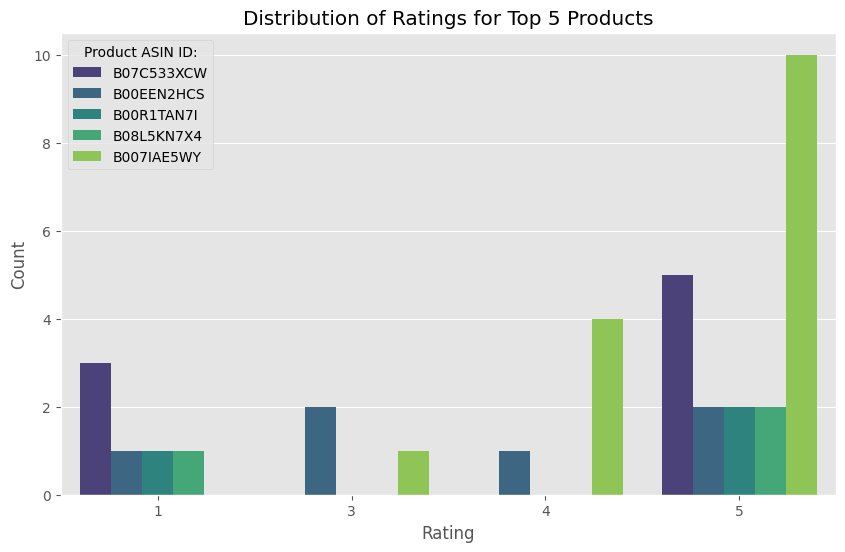

In [87]:
# Visualizations for top products

# Bar plot for the distribution of ratings for top products
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', 
              data=top_products_df, 
              palette='viridis', 
              hue='asin')
plt.title('Distribution of Ratings for Top 5 Products')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.legend(title='Product ASIN ID:')
plt.show()

In [84]:
# Compare Rating and Sentiment to identify any discrepancies for top products
top_rating_sentiment_grouped = top_products_df.groupby(['rating', 
                                                        'llm_sentiment']).size().unstack().fillna(0)
print(top_rating_sentiment_grouped)

llm_sentiment  negative  neutral  positive
rating                                    
1                   6.0      0.0       0.0
3                   2.0      1.0       0.0
4                   0.0      0.0       5.0
5                   0.0      1.0      20.0


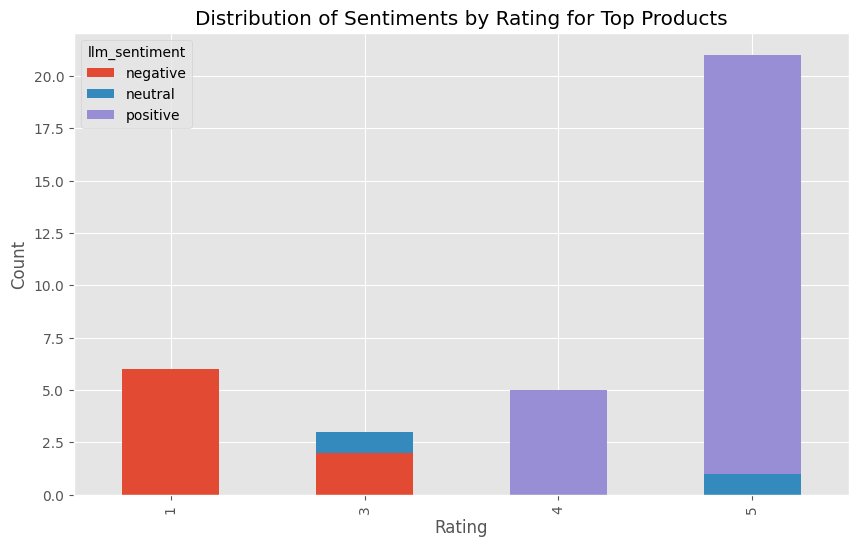

In [85]:
# Plots the distribution of each sentiment a a stacked bar plot per Rating
top_rating_sentiment_grouped.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Distribution of Sentiments by Rating for Top Products')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

## Plot Box Analysis:
Box plot provides a visual representation of the distribution of ratings across different sentiment categories for the top 5 products, allowing you to easily compare their performance and identify any patterns or discrepancies.

### How to read the next box plot results
X-Axis (Sentiment):
* The x-axis represents the different sentiment categories (e.g., positive, negative, neutral).
Y-Axis (Rating):
* The y-axis represents the ratings given by customers.

#### Insight 1: Boxes for Each Product and Sentiment:
* Each box represents the distribution of ratings for a specific product and sentiment category.
* The different colors of the boxes help distinguish between the products, as indicated by the legend.

#### Interpreting the Box Plot:
* Median: The horizontal line inside each box represents the median rating for that product and sentiment category.
* Interquartile Range (IQR): The box itself represents the interquartile range, which is the range between the 25th percentile (Q1) and the 75th percentile (Q3) of the ratings.
* Whiskers: The lines extending from the box (whiskers) represent the range of ratings within 1.5 times the IQR from the lower and upper quartiles.
* Outliers: Individual points outside the whiskers represent outliers, which are ratings that fall outside the typical range.

#### Insight 2: Example Interpretation
* Comparing Medians: By comparing the median lines within the boxes, you can see which products tend to have higher or lower ratings for each sentiment category.
* Distribution Spread: The size of the boxes and the length of the whiskers indicate the spread of the ratings. A larger box or longer whiskers suggest more variability in the ratings.
* Outliers: Outliers can indicate unusual ratings that are significantly higher or lower than the rest of the data.

#### Example Analysis
* If a product has a consistently high median rating across all sentiment categories, it suggests that the product is generally well-received.
* If the median rating for a product is lower in the negative sentiment category compared to the positive sentiment category, it indicates that negative reviews tend to give lower ratings.
* Comparing the spread of the boxes can help identify products with more consistent ratings versus those with more variability.

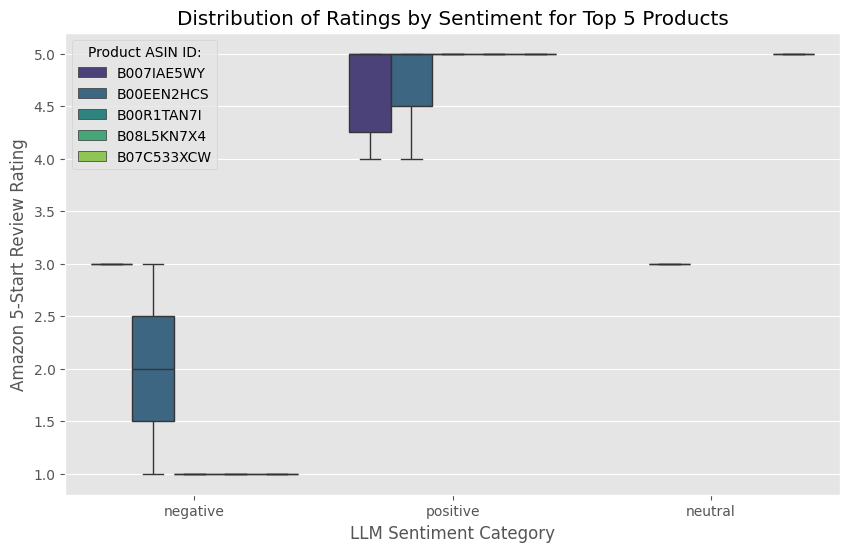

In [89]:
# Box plot to compare the distribution of ratings across different sentiments for top products
plt.figure(figsize=(10, 6))
sns.boxplot(x='llm_sentiment', 
            y='rating', 
            data=top_products_df, 
            palette='viridis', 
            hue='asin')
plt.title('Distribution of Ratings by Sentiment for Top 5 Products')
plt.xlabel('LLM Sentiment Category')
plt.ylabel('Amazon 5-Start Review Rating')
plt.legend(title='Product ASIN ID:')
plt.show()

To create combined plots for each distinct analysis for the top 5 products using Seaborn, we can use subplots to display multiple plots in a single figure. This will allow us to compare the distribution of ratings, sentiments, and trends over time for the top 5 products in a more granular way.

C:\Users\diegomartos\AppData\Local\Temp\ipykernel_19528\3992176103.py:37: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



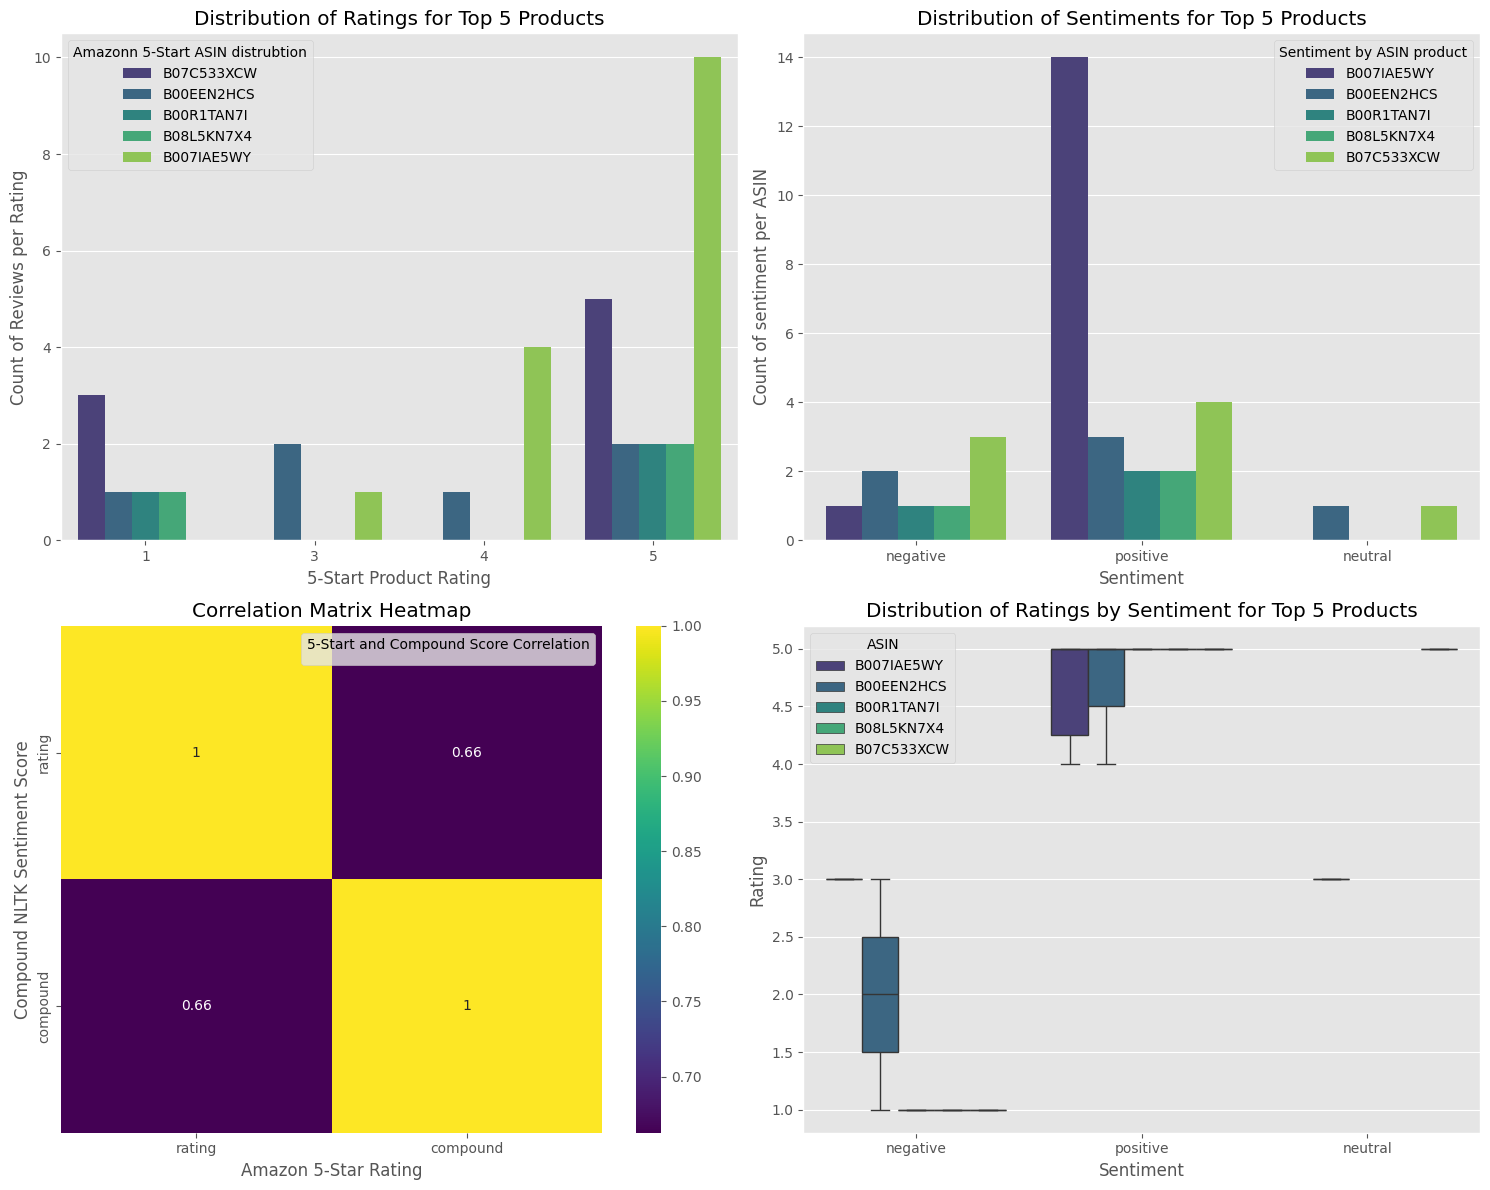

In [90]:
# Set up the matplotlib figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Bar plot for the distribution of ratings for top products
sns.countplot(x='rating', 
              data=top_products_df, 
              palette='viridis', 
              hue='asin', 
              ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Ratings for Top 5 Products')
axes[0, 0].set_xlabel('5-Start Product Rating')
axes[0, 0].set_ylabel('Count of Reviews per Rating')
axes[0, 0].legend(title='Amazonn 5-Start ASIN distrubtion')

# Bar plot for the distribution of sentiments for top products
sns.countplot(x='llm_sentiment', 
              data=top_products_df, 
              palette='viridis', 
              hue='asin', 
              ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Sentiments for Top 5 Products')
axes[0, 1].set_xlabel('Sentiment')
axes[0, 1].set_ylabel('Count of sentiment per ASIN')
axes[0, 1].legend(title='Sentiment by ASIN product')


# Calculate the correlation matrix for numerical features
correlation_matrix = top_products_df[['rating', 
                                      'compound']].corr()
# Heatmap for the correlation matrix of the top products and their ratings and sentiment
sns.heatmap(correlation_matrix, 
            annot=True, cmap='viridis', 
            ax=axes[1, 0])
axes[1, 0].set_title('Correlation Matrix Heatmap')
axes[1, 0].set_xlabel('Amazon 5-Star Rating')
axes[1, 0].set_ylabel('Compound NLTK Sentiment Score')
axes[1, 0].legend(title='5-Start and Compound Score Correlation')

# Box plot to compare the distribution of ratings across different sentiments for top products
sns.boxplot(x='llm_sentiment', 
            y='rating', 
            data=top_products_df, 
            palette='viridis', 
            hue='asin', 
            ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Ratings by Sentiment for Top 5 Products')
axes[1, 1].set_xlabel('Sentiment')
axes[1, 1].set_ylabel('Rating')
axes[1, 1].legend(title='ASIN')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Part 3 - Chatting with the data using Large Language Model

It is possible to use Azure OpenAI's Chat Completion to ask questions about the customer ratings, products, etc., using the nlp_combined_df DataFrame. You can achieve this by converting the DataFrame into a format that can be processed by the model and then querying the model with specific questions.

`Prompt engineering` is a crucial aspect of leveraging large language models (LLMs) for successful solutions, especially when working with structured data. It involves crafting precise and contextually relevant prompts to guide the model's responses effectively. This process ensures that the LLM understands the task at hand and generates accurate, meaningful outputs. In the context of data science, prompt engineering helps in extracting valuable insights from structured data, enhancing the analysis, and making data-driven decisions more efficient.

#### Key Concepts and Importance:
- **Precision**: Crafting clear and specific prompts to minimize ambiguity and ensure the model's responses are on target.
- **Contextual Relevance**: Ensuring prompts are relevant to the data and the specific analysis required, which helps in obtaining more accurate results.
- **Iterative Refinement**: Continuously refining prompts based on the model's outputs to improve the quality and relevance of the responses.

#### Pros:
- **Enhanced Accuracy**: Well-crafted prompts lead to more accurate and relevant outputs from the LLM.
- **Efficiency**: Saves time by providing precise instructions, reducing the need for extensive post-processing.
- **Flexibility**: Allows for a wide range of applications and analyses by adjusting the prompts accordingly.

#### Cons:
- **Complexity**: Crafting effective prompts can be challenging and requires a deep understanding of both the data and the model.
- **Dependency**: Over-reliance on prompt engineering might limit the exploration of other analytical methods.
- **Resource Intensive**: Iterative refinement of prompts can be time-consuming and resource-intensive.

#### Important Aspects:
- **Understanding the Data**: A thorough understanding of the structured data is essential to create relevant prompts.
- **Model Capabilities**: Knowledge of the LLM's strengths and limitations helps in designing effective prompts.
- **Feedback Loop**: Establishing a feedback loop to refine prompts based on the model's performance and outputs.

By mastering prompt engineering, data scientists can harness the full potential of LLMs, leading to more insightful and actionable data analyses.

For this project, the following table summarizes the guidance, characteristics, and thought requirements for the agent to perform the analysis.

| **Attribute** | **Property** | **Short Comment** |
|---------------|--------------|-------------------|
| **Question** | Reviews (ratings 4 or 5) and positive sentiment analysis | Determine top specific topics that reflect product aspects customers appreciate |
| **Prompt** | Customer ratings data and question | Analyze data to identify specific, understandable topics associated with positive reviews |
| **Agent Role** | Senior marketing assistant | Provide product sales analysis on Amazon Product Purchase and evaluate correlation with Amazon Review Star Ratings and sentiment analysis |
| **Purpose** | Help sellers analyze customer ratings data | Identify specific topics associated with positive and negative reviews |
| **Presentation** | Short phrases | Make each sentiment's focus clear |
| **Trend Summary** | Mentions of topics | Determine if mentions are increasing, decreasing, or steady; note spikes or dips |
| **ASIN List** | Unique ASINs | Provide a list of unique products observed from ASIN column |
| **Rating Distribution** | Amazon Review Rating Distribution | Provide overall rating distribution and speculate on possible reasons |
| **Star Ratings Analysis** | 1 to 5 Star Reviews | Evaluate trends or outliers for each rating in the context of sentiment analysis |
| **Trend Summary** | Overall trends | Summarize trends for each topic |
| **Sentiment Insights** | Per Review | Provide insights based on sentiment analysis |
| **Influencing Findings** | Most Influencing Findings | Identify key findings influencing the ratings |
| **Recommendations** | For Improvement | Provide recommendations based on analysis |
| **Other Insights** | Relevant Insights | Note any additional relevant insights |



This approach allows you to ask questions about the customer ratings, products, etc., using the nlp_combined_df DataFrame and get answers from the Azure OpenAI Chat Completion API.

Here is an example of how to implement this:

### Step 1: JSON vs Pandas data format - Choosing the best format to handle the data with performance efficiency in mind

When considering token consumption for running Azure OpenAI LLM models, the format of the data can significantly impact the number of tokens used. Here are some considerations for choosing between Pandas DataFrame format and JSON format:

### Advantage of JSON Format

Pros:
* JSON is a widely accepted format for data interchange and is easily readable by LLM models.
* It can be more compact than a DataFrame when serialized, especially if the DataFrame has many columns with repetitive data.

Cons:
* JSON serialization can sometimes add extra characters (e.g., braces, quotes) that increase token count.
P
### Advantage of Pandas DataFrame Format

Pros:
* Directly working with DataFrame can be more efficient for in-memory operations and manipulations.
* When converted to a string representation, it can be more concise if the DataFrame is small.

Cons:
* Converting a DataFrame to a string format for LLM input can sometimes be less compact than JSON, especially if the DataFrame is large.

### LLM Processing - Acccounting for Token Efficiency Considerations

Compact Representation: 
* Choose the format that provides a more compact representation of your data.
Data Size: 
* For smaller datasets, the difference might be negligible. For larger datasets, JSON might be more efficient.
Preprocessing: 
* Preprocess the data to remove unnecessary columns and rows to reduce token count.

### Step 2: Convert the DataFrame to a JSON-like format

* data_json: Converts the DataFrame to a dictionary format.
* data_str: Converts the dictionary to a JSON string.

Here is a step-by-step approach to achieve this:

* Convert the DataFrame to a JSON-like format: This will allow the model to understand the structure of the data.
* Create a prompt with the data and the question: This will be sent to the Azure OpenAI Chat Completion API.
* Send the prompt to the API and get the response: This will provide the answer to the question based on the data.

In [ ]:
## Optional Step: Convert the DataFrames to JSON

# Import the JSON library
#import json

# Convert the DataFrame to a JSON-like format
#top_positive_data_json = top_positive_df.to_dict(orient='records')
# Convert the JSON-like format to a string
#top_positive_data_str = json.dumps(top_positive_data_json, indent=2)

# Converts Negative Data frame to JSON Format
#top_negative_data_json = top_negative_df.to_dict(orient='records')
# Converts Neutral Data frame to JSON Format
#top_neutral_data_json = top_neutral_df.to_dict(orient='records')

# Converts Neutral Data frame to JSON Format
#top_neutral_data_json = top_neutral_df.to_dict(orient='records')
# Converts Neutral Data frame to JSON Format
#top_neutral_data_json = top_neutral_df.to_dict(orient='records')

## Positive Reviews - Product Insights and Report with summary

To make the LLM analysis focused on the subset of 4 and 5 Start ratings, let's split the top products with highest reviews and only work with those records that have a high rating (4 and 5). But let's actually split this data into a subset using the rows as Positive, as this is what we expect to see based on previous data analysis

### Step 1: Splits the top_products_df into three dataframes based on the Sensitivity of the Sentiment Column


In [ ]:
# Filter the DataFrame to include only the records with 'POSITIVE' sentiment
top_positive_df = top_products_df[top_products_df['llm_sentiment'] == 'positive']
# displays the shape of the top_positive_df
top_positive_df.shape

(25, 22)

### Step 2: Create a prompt with the data and the question

Whem working with GPT and other LLM Models, it is important to provide a context and a clear / objective instruction on what you are looking to extract from the data.

The following are two important settings that will influence on how the LLM will evaluate the product review:

* question: Defines the question to be asked.
* prompt: Combines the data and the question into a single prompt.


In [95]:
# Defines the question
question = "For Reviews (ratings 4 or 5) and positive sentiment analysis, \
    determine the top specific topics that reflect product aspects that \
        customers appreciate, using clear language (e.g., 'pleasant scent' or 'durable packaging'). \
            These topics should reveal aspects of the brand or product that are motivating buyers \
                to leave positive reviews." 
# Creates the prompt
prompt = f"""
Here is the customer ratings data: {top_positive_df}
Question: {question}
"""

# Defines the agent message and prompt behavior
agent = f"""
You are a senior marketing assistant in charge to provide product sales on Amazon Product Purchase and \
evaluate possible correlation, or the lack of it, in regards of Amazon Review Start Ratings and sentiment analysis left by \
the comments by the customer. The purpose is to help sellers to analyze customer ratings data on product purchase review.\
You will help to analyze the product review data to identify specific, \
    understandable topics associated with positive and negative reviews based on the data set.\
    Present these topics as short phrases that make each sentiment's focus clear· \
        Provide a trend summary for each topic. \
            Are mentions of this topic increasing, decreasing, or remaining steady? \
                Have there been any spikes or dips in mentions of this product over time? \
                    Provide a list of the ASINs that are associated with each topic. \
                    For each topic, provide the following information: \
                        1. Unique ASINs: (Provide a list of unique products observed from ASIN column in the dataframe)\
                        2. Amazon Review Rating Distribution: (Provide an overall rating distribution of the products, and expeculate on the possible reasons for the distribution). \
                        for each of the Star Rating Below, in the context of the sentiment analysis in the ask (positive, negative or neutral), evaluate trends or possible outliers \
                        between the rating and this rating value. (If evaluating positive sentiment analysis, it is expected to see more 4 and 5 star ratings, \
                        and less 1, 2, and 3 star ratings. If evaluating negative sentiment analysis, it is expected to see more 1, 2 and 3 star ratings, and less 4 and 6 star ratings.\
                        If the evaluating neutral sentiment analysis, identify any possible patterns that could justify personal preferences and other factors leading to an \
                        aparent randomness with some hidding sinals found in the words of the customer review) \
                        2.1 Star Review: (e.g.: Few observed, mainly concentrated later in the month and likely because of a specific event like packing problems)
                        2.2 Stars Review: (e.g.: Few early in the month, and based on reviews, it is likely due to a specific event like a product recall)
                        2.3 Stars Review: (e.g.: More common and persistent through the data set period)   
                        2.4 Stars Review: (e.g.: more common and mainly obseved in the end on the month, check for possible sales or promotions)
                        2.5 Stars: Occasional (e.g.: less common and observed at random intervals, check for possible sales or promotions or new product launch)
                        2. Trend Summary: \
                        3. Sentiment Insights Per Review: \
                        4. Most Influencing Findings Influencing the Ratings: \
                        5. Recommendations for Improvement: \
                        6. Other Relevant Insights:
                    """

### Step 3: Send the prompt to the API and get the response
* Creates an Azure OpenAI client.
* Sends the prompt to the Chat Completion API.
* Extracts and prints the answer from the response.

The first thing we need to do is to optimize the performance by grouping the data into two main Groups, the group of negative sentiment, with ratings of 1, 2 and 3, and the second group with positive sentiment and ratings of 4 and 5.

We also need to check for possible outliers where Ratings and Sentiment assessment is not fully aligned (example positive sentiment assessment for Ratings 1, 2 and 3, or Negative Sentiment assessment with Rating 4 or 5.)

In [96]:
# Define the deployment name for the model
deployment_name = 'gpt-4'

# Send the prompt to the API and get the response
llm = client.chat.completions.create(
    model=deployment_name,
    messages=[
        {"role": "system", "content": agent},
        {"role": "user", "content": prompt}
    ]
)

# Extract the answer from the response
answer = llm.choices[0].message.content.strip()

# Print the answer
print(answer)

To identify specific, easily understandable topics associated with positive reviews (ratings 4 or 5) and positive sentiment analysis, we can analyze the customer review text and titles for commonly mentioned positive aspects and phrases. Here's a high-level categorization:

### Specific Topics for Positive Reviews *(based on extracted keywords, phrases, and customer satisfaction)*:

1. **Exfoliation Quality**:
   - Phrases like "exfoliate your tucass off!", "daily exfoliation" and "exfoliates well," indicate customers appreciate the effective exfoliation properties of products like washcloths (ASIN B007IAE5WY).
  
2. **Product Effectiveness**:
   - Terms like "Plaque buster!!", "clears nicely", "amazing product" suggest that customers value how well the product performs its intended function (ASINs: B08L5KN7X4, etc.).

3. **Ease of Use**:
   - Customers highlight the "easy to use" aspect in several reviews, appreciating the straightforward usability and convenience (e.g., compact hairb

## Negative Reviews

### Step 1: Splits the top_products_df into a negative dataframe subset based on the Sensitivity of the Sentiment Column



In [93]:
# Filter the DataFrame to include only the records with 'NEUTRAL' sentiment
top_negative_df = top_products_df[top_products_df['llm_sentiment'] == 'negative']
# displays the shape of the top_negative_df
top_negative_df.shape

(8, 22)

### Step 2: Create a prompt with the data and the question
* question: Defines the question to be asked.
* prompt: Combines the data and the question into a single prompt.

In [98]:
# Defines the question
neg_question = "For negative reviews (ratings 1, 2, or 3), identify the top specific topics that capture \
    common customer complaints or issues, using precise wording (e.g., 'tablets do not fully dissolve' \
        or 'pump mechanism fails'). These topics should reveal aspects of the brand or product that are motivating\
              buyers to leave negative reviews. Present these topics as short phrases that \
                 make each sentiment's focus clear· Provide a trend summary for each topic. \
                    Are mentions of this topic increasing, decreasing, or remaining steady? \
                        Have there been any spikes or dips in mentions of this product over time?"
# Creates the prompt
neg_prompt = f"""
Here is the customer ratings data: {top_negative_df}
Question: {neg_question}
"""

# Defines the agent message and prompt behavior
agent = f"""
You are a senior marketing assistant in charge to provide product sales on Amazon Product Purchase and \
evaluate possible correlation, or the lack of it, in regards of Amazon Review Start Ratings and sentiment analysis left by \
the comments by the customer. The purpose is to help sellers to analyze customer ratings data on product purchase review.\
You will help to analyze the product review data to identify specific, \
    understandable topics associated with positive and negative reviews based on the data set.\
    Present these topics as short phrases that make each sentiment's focus clear· \
        Provide a trend summary for each topic. \
            Are mentions of this topic increasing, decreasing, or remaining steady? \
                Have there been any spikes or dips in mentions of this product over time? \
                    Provide a list of the ASINs that are associated with each topic. \
                    For each topic, provide the following information: \
                        1. Unique ASINs: (Provide a list of unique products observed from ASIN column in the dataframe)\
                        2. Amazon Review Rating Distribution: (Provide an overall rating distribution of the products, and expeculate on the possible reasons for the distribution). \
                        for each of the Star Rating Below, in the context of the sentiment analysis in the ask (positive, negative or neutral), evaluate trends or possible outliers \
                        between the rating and this rating value. (If evaluating positive sentiment analysis, it is expected to see more 4 and 5 star ratings, \
                        and less 1, 2, and 3 star ratings. If evaluating negative sentiment analysis, it is expected to see more 1, 2 and 3 star ratings, and less 4 and 6 star ratings.\
                        If the evaluating neutral sentiment analysis, identify any possible patterns that could justify personal preferences and other factors leading to an \
                        aparent randomness with some hidding sinals found in the words of the customer review) \
                        2.1 Star Review: (e.g.: Few observed, mainly concentrated later in the month and likely because of a specific event like packing problems)
                        2.2 Stars Review: (e.g.: Few early in the month, and based on reviews, it is likely due to a specific event like a product recall)
                        2.3 Stars Review: (e.g.: More common and persistent through the data set period)   
                        2.4 Stars Review: (e.g.: more common and mainly obseved in the end on the month, check for possible sales or promotions)
                        2.5 Stars: Occasional (e.g.: less common and observed at random intervals, check for possible sales or promotions or new product launch)
                        2. Trend Summary: \
                        3. Sentiment Insights Per Review: \
                        4. Most Influencing Findings Influencing the Ratings: \
                        5. Recommendations for Improvement: \
                        6. Other Relevant Insights:
                    """

### Step 3: Send the prompt to the API and get the response
* Creates an Azure OpenAI client.
* Sends the prompt to the Chat Completion API.
* Extracts and prints the answer from the response.

The first thing we need to do is to optimize the performance by grouping the data into two main Groups, the group of negative sentiment, with ratings of 1, 2 and 3, and the second group with positive sentiment and ratings of 4 and 5.

We also need to check for possible outliers where Ratings and Sentiment assessment is not fully aligned (example positive sentiment assessment for Ratings 1, 2 and 3, or Negative Sentiment assessment with Rating 4 or 5.)

In [99]:
# Define the deployment name for the model
deployment_name = 'gpt-4'

# Send the prompt to the API and get the response
llm = client.chat.completions.create(
    model=deployment_name,
    messages=[
        {"role": "system", "content": agent},
        {"role": "user", "content": neg_prompt}
    ]
)

# Extract the answer from the response
answer = llm.choices[0].message.content.strip()

# Print the answer
print(answer)

# Top Specific Topics Identified from Negative Reviews

## 1. "Product Damaged or Defective"
- Examples:
  - "Extremely disappointed the bottle is damaged" (B07C533XCW)
  - "Didn’t change color much and stained everything" (B00EEN2HCS)
  
### Trend Summary:
- **Frequency**: This issue is mentioned in multiple reviews spanning from 2020 to 2022.
- **Trend Pattern**: The mentions appear to be steady over time, but more concentrated around the years 2020 and onwards.
- **Spikes/Dips**: An observable concentration of complaints is present in 2020, especially around July, indicating a potential issue in product quality or shipping during this period.

## 2. "Unpleasant Odor or Bad Smell"
- Examples:
  - "Has a bad smell. Smells like old stale water" (B07C533XCW)
  
### Trend Summary:
- **Frequency**: Mentioned sporadically across reviews.
- **Trend Pattern**: The mentions do not show a clear pattern, appearing randomly over the studied timeline.
- **Spikes/Dips**: Identified specifically in

## Neutral Reviews

### Step 1: Splits the top_products_df into a neutral dataframe subset based on the Sensitivity of the Sentiment Column

In [94]:
# Filter the DataFrame to include only the records with 'NEUTRAL' sentiment
top_neutral_df = top_products_df[top_products_df['llm_sentiment'] == 'neutral']
# displays the shape of the top_neutral_df
top_neutral_df.shape

(2, 22)


### Step 2: Create a prompt with the data and the question
* question: Defines the question to be asked.
* prompt: Combines the data and the question into a single prompt.

In [100]:
# Defines the question
neu_question = "For neutral reviews, what are the insights and conclusions, as well is what is the range of ratings (ratings 1, 2, 3, 4 or 5), identify the top specific topics that capture \
    common customer most repeated words or message intent, complaints or issues, using precise wording (e.g., 'tablets do not fully dissolve' \
        or 'pump mechanism fails', 'just more of the same', etc..). These topics should reveal aspects of the brand or product that are motivating\
              buyers to leave negative reviews. Present these topics as short phrases that \
                 make each sentiment's focus clear· Provide a trend summary for each topic. \
                    Are mentions of this topic increasing, decreasing, or remaining steady? \
                        Have there been any spikes or dips in mentions of this product over time?"
# Creates the prompt
neu_prompt = f"""
Here is the customer ratings data: {top_neutral_df}
Question: {neu_question}
"""

# Defines the agent message and prompt behavior
agent = f"""
You are a senior marketing assistant in charge to provide product sales on Amazon Product Purchase and \
evaluate possible correlation, or the lack of it, in regards of Amazon Review Start Ratings and sentiment analysis left by \
the comments by the customer. The purpose is to help sellers to analyze customer ratings data on product purchase review.\
You will help to analyze the product review data to identify specific, \
    understandable topics associated with positive and negative reviews based on the data set.\
    Present these topics as short phrases that make each sentiment's focus clear· \
        Provide a trend summary for each topic. \
            Are mentions of this topic increasing, decreasing, or remaining steady? \
                Have there been any spikes or dips in mentions of this product over time? \
                    Provide a list of the ASINs that are associated with each topic. \
                    For each topic, provide the following information: \
                        1. Unique ASINs: (Provide a list of unique products observed from ASIN column in the dataframe)\
                        2. Amazon Review Rating Distribution: (Provide an overall rating distribution of the products, and expeculate on the possible reasons for the distribution). \
                        for each of the Star Rating Below, in the context of the sentiment analysis in the ask (positive, negative or neutral), evaluate trends or possible outliers \
                        between the rating and this rating value. (If evaluating positive sentiment analysis, it is expected to see more 4 and 5 star ratings, \
                        and less 1, 2, and 3 star ratings. If evaluating negative sentiment analysis, it is expected to see more 1, 2 and 3 star ratings, and less 4 and 6 star ratings.\
                        If the evaluating neutral sentiment analysis, identify any possible patterns that could justify personal preferences and other factors leading to an \
                        aparent randomness with some hidding sinals found in the words of the customer review) \
                        2.1 Star Review: (e.g.: Few observed, mainly concentrated later in the month and likely because of a specific event like packing problems)
                        2.2 Stars Review: (e.g.: Few early in the month, and based on reviews, it is likely due to a specific event like a product recall)
                        2.3 Stars Review: (e.g.: More common and persistent through the data set period)   
                        2.4 Stars Review: (e.g.: more common and mainly obseved in the end on the month, check for possible sales or promotions)
                        2.5 Stars: Occasional (e.g.: less common and observed at random intervals, check for possible sales or promotions or new product launch)
                        2. Trend Summary: \
                        3. Sentiment Insights Per Review: \
                        4. Most Influencing Findings Influencing the Ratings: \
                        5. Recommendations for Improvement: \
                        6. Other Relevant Insights:
                    """

### Step 3: Send the prompt to the API and get the response
* Creates an Azure OpenAI client.
* Sends the prompt to the Chat Completion API.
* Extracts and prints the answer from the response.

The first thing we need to do is to optimize the performance by grouping the data into two main Groups, the group of negative sentiment, with ratings of 1, 2 and 3, and the second group with positive sentiment and ratings of 4 and 5.

We also need to check for possible outliers where Ratings and Sentiment assessment is not fully aligned (example positive sentiment assessment for Ratings 1, 2 and 3, or Negative Sentiment assessment with Rating 4 or 5.)

In [101]:
# Define the deployment name for the model
deployment_name = 'gpt-4'

# Send the prompt to the API and get the response
llm = client.chat.completions.create(
    model=deployment_name,
    messages=[
        {"role": "system", "content": agent},
        {"role": "user", "content": neu_prompt}
    ]
)

# Extract the answer from the response
answer = llm.choices[0].message.content.strip()

# Print the answer
print(answer)

#### Insights and Conclusions for Neutral Reviews:
From the provided data, there are two reviews marked as neutral, one rated as 3 stars and the other as 5 stars. This indicates that even though the sentiment analysis classified the subjective feelings of customers as neutral, the actual star ratings can vary.

#### Range of Ratings:
- **3 Stars:** 1 instance (50% of neutral reviews)
- **5 Stars:** 1 instance (50% of neutral reviews)

Since there are only two instances of neutral reviews in this sample, it is impossible to derive meaningful overall trends or detailed insights with statistical significance. However, from the available data, a few observations can still be highlighted.

### Top Specific Topics Identified:
From the limited data provided:
1. **Color Mismatch** - "Needed a darker color."
2. **General Satisfaction** - "It was ok."

These topics don't imply heavy discontent but rather mild inconvenience or ambivalence toward the product.

### Trend Summary for Each Topic:
1. 